## 1. INITIATION & READING DATA

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', -1)

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

print('** M5 - FORECASTING - ACCURACY **')
print("-"*25)

import gc
import os
for x in os.listdir("input/"):
    print(x)
print("-"*25)

print ("Initiation is DONE !!")
print("-"*25)

** M5 - FORECASTING - ACCURACY **
-------------------------
calendar.csv
sales_train_evaluation.csv
sales_train_validation.csv
sample_submission.csv
sell_prices.csv
-------------------------
Initiation is DONE !!
-------------------------


In [2]:
##### SOME USEFULL FUNCTIONS

## TIMER
import time
from contextlib import contextmanager
@contextmanager
def timer():
    t0 = time.time()
    yield
    t1 = time.time()
    print( 'Runtime: ' + str(round(t1-t0,2)) + ' sn' )

In [3]:
path = 'input/'
out_path = 'output/'

with timer():
    calendar   = pd.read_csv( f'{path}calendar.csv')
#    train_v    = pd.read_csv( f'{path}sales_train_validation.csv')
    train      = pd.read_csv( f'{path}sales_train_evaluation.csv')
    prices     = pd.read_csv( f'{path}sell_prices.csv')
    submission = pd.read_csv( f'{path}sample_submission.csv')

print('Reading Data is DONE !!')
print("-"*25)

print( f'calendar   shape :  {calendar.shape}    ')
# print( f'train_v    shape :  {train_v.shape}     ')
print( f'train    shape   :  {train.shape}     ')
print( f'prices     shape :  {prices.shape}      ')
print( f'submission shape :  {submission.shape}  ')

Runtime: 6.56 sn
Reading Data is DONE !!
-------------------------
calendar   shape :  (1969, 14)    
train    shape   :  (30490, 1947)     
prices     shape :  (6841121, 4)      
submission shape :  (60980, 29)  


## 2. BASIC PREPROCESSING

### 2.1. TRAIN DATA PREPARATION

In [4]:
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES  CA_1      
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES  CA_1      
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES  CA_1      
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES  CA_1      
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES  CA_1      

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0  CA       0    0    0    0    0    0    0    0    0    0     0     0      
1  CA       0    0    0    0    0    0    0    0    0    0     0     0      
2  CA       0    0    0    0    0    0    0    0    0    0     0     0      
3  CA       0    0    0    0    0    0    0    0    0    0     0     0      
4  CA       0    0    0    0    0    0    0    0    0    0     0     0      

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     0     0     0     0     0     0     0     0     0     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     0     0     0     0     0     0     0     0     0     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  2     0     0     0     2     0     1     0     0     0     0     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     2     0     1     0     0     1     1     1     0     2     3      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  1     0     0     0     0     0     1     0     0     1     1     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     1     0     0     1     2     3     0     2     0     0     2      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      


In [5]:
train['id'] = train['item_id'] + '_' + train['store_id']
print(train.shape)
print('-'*25)
train.head()

(30490, 1947)
-------------------------


id        item_id    dept_id   cat_id store_id state_id  \
0  HOBBIES_1_001_CA_1  HOBBIES_1_001  HOBBIES_1  HOBBIES  CA_1     CA        
1  HOBBIES_1_002_CA_1  HOBBIES_1_002  HOBBIES_1  HOBBIES  CA_1     CA        
2  HOBBIES_1_003_CA_1  HOBBIES_1_003  HOBBIES_1  HOBBIES  CA_1     CA        
3  HOBBIES_1_004_CA_1  HOBBIES_1_004  HOBBIES_1  HOBBIES  CA_1     CA        
4  HOBBIES_1_005_CA_1  HOBBIES_1_005  HOBBIES_1  HOBBIES  CA_1     CA        

   d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  d_13  d_14  \
0  0    0    0    0    0    0    0    0    0    0     0     0     0     0      
1  0    0    0    0    0    0    0    0    0    0     0     0     0     0      
2  0    0    0    0    0    0    0    0    0    0     0     0     0     0      
3  0    0    0    0    0    0    0    0    0    0     0     0     0     0      
4  0    0    0    0    0    0    0    0    0    0     0     0     0     0      

   d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  d_25  d_26  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     0     0     0     0     0     0     0     0     0     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  d_37  d_38  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     0     0     0     0     0     0     0     0     2     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  d_49  d_50  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     2     0     1     0     0     0     0     0     0     2      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  d_61  d_62  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     1     0     0     1     1     1     0     2     3     1     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  d_73  d_74  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     0     0     1     0     0     1     1     0     0     1      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  d_85  d_86  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0     0     0      
3  0     0     1     2     3     0     2     0     0     2     2     0      
4  0     0     0     0     0     0     0     0     0     0     0     0      

   d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  d_97  d_98  \
0  0     0     0     0     0     0     0     0     0     0     0     0      
1  0     0     0     0     0     0     0     0     0     0     0     0      
2  0     0     0     0     0     0     0     0     0     0  

In [6]:
# Making data usable in models
with timer():
    train = pd.melt( train,
                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                     value_vars = [col for col in train.columns if col.startswith("d_")],
                     var_name = "d",
                     value_name = "sales")
with timer():
    train['d']     = train['d'].str.extract('(\d+)').astype('int16')
    train['sales'] = train['sales'].astype('int16')


with timer():
    train.sort_values(['id', 'd'], inplace=True)


print(train.shape)
print('-'*25)
train.tail()

Runtime: 10.96 sn
Runtime: 110.85 sn
Runtime: 63.51 sn
(59181090, 8)
-------------------------


id          item_id      dept_id     cat_id  \
59057692  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
59088182  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
59118672  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
59149162  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
59179652  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  
59057692  WI_3     WI       1937  0      
59088182  WI_3     WI       1938  0      
59118672  WI_3     WI       1939  0      
59149162  WI_3     WI       1940  0      
59179652  WI_3     WI       1941  0

In [7]:
# Adding the 28 days we try to forecast
with timer():
    tmp = train.groupby('id', as_index=False ).tail(28)
    tmp['d'] = tmp['d'] + 28
    tmp['sales'] = np.nan
    print(tmp.shape)

with timer():
    train = pd.concat([train,tmp], axis=0, sort=False, ignore_index=True)

del tmp; gc.collect()

with timer():
    train.sort_values(['id', 'd'], inplace=True)
    train.reset_index(drop=True, inplace=True)
    
print(train.shape)
print('-'*25)
train.tail()

(853720, 8)
Runtime: 6.14 sn
Runtime: 1.85 sn
Runtime: 22.1 sn
(60034810, 8)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  
60034805  WI_3     WI       1965 NaN     
60034806  WI_3     WI       1966 NaN     
60034807  WI_3     WI       1967 NaN     
60034808  WI_3     WI       1968 NaN     
60034809  WI_3     WI       1969 NaN

### 2.2. CALENDAR DATA PREPARATION

In [8]:
print(calendar.shape)
print('-'*25)
calendar.tail()

(1969, 14)
-------------------------


date  wm_yr_wk    weekday  wday  month  year       d  \
1964  2016-06-15  11620     Wednesday  5     6      2016  d_1965   
1965  2016-06-16  11620     Thursday   6     6      2016  d_1966   
1966  2016-06-17  11620     Friday     7     6      2016  d_1967   
1967  2016-06-18  11621     Saturday   1     6      2016  d_1968   
1968  2016-06-19  11621     Sunday     2     6      2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
1964  NaN           NaN          NaN           NaN          0        1         
1965  NaN           NaN          NaN           NaN          0        0         
1966  NaN           NaN          NaN           NaN          0        0         
1967  NaN           NaN          NaN           NaN          0        0         
1968  NBAFinalsEnd  Sporting     Father's day  Cultural     0        0         

      snap_WI  
1964  1        
1965  0        
1966  0        
1967  0        
1968  0

In [9]:
with timer():
    calendar['d'] = calendar['d'].str.extract('(\d+)').astype('int16')
    
    for col in ['wday', 'month']:
        calendar[col] = calendar[col].astype('int8')
    
    for col in ['wm_yr_wk', 'year']:
        calendar[col] = calendar[col].astype('int16')
    
    calendar.drop(['date', 'weekday'], axis=1, inplace=True)
        
print(calendar.shape)
print('-'*25)
calendar.tail()

Runtime: 0.01 sn
(1969, 12)
-------------------------


wm_yr_wk  wday  month  year     d  event_name_1 event_type_1  \
1964  11620     5     6      2016  1965  NaN           NaN           
1965  11620     6     6      2016  1966  NaN           NaN           
1966  11620     7     6      2016  1967  NaN           NaN           
1967  11621     1     6      2016  1968  NaN           NaN           
1968  11621     2     6      2016  1969  NBAFinalsEnd  Sporting      

      event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
1964  NaN           NaN          0        1        1        
1965  NaN           NaN          0        0        0        
1966  NaN           NaN          0        0        0        
1967  NaN           NaN          0        0        0        
1968  Father's day  Cultural     0        0        0

In [10]:
## DO NOT FORGET TO ADD SNAP DATA
snap = calendar[['d', 'snap_CA', 'snap_TX', 'snap_WI']]

snap = pd.melt( snap,
                     id_vars = ['d'],
                     value_vars = [col for col in snap.columns if col.startswith("snap_")],
                     var_name = "state_id",
                     value_name = "is_snap")

snap['state_id'] = snap['state_id'].str[5:].astype('category')
snap['is_snap'] = snap['is_snap'].astype('int8')

print(snap.shape)
print('-'*25)
snap.tail()

(5907, 3)
-------------------------


d state_id  is_snap
5902  1965  WI       1      
5903  1966  WI       0      
5904  1967  WI       0      
5905  1968  WI       0      
5906  1969  WI       0

In [11]:
calendar.drop(['snap_CA', 'snap_TX', 'snap_WI'], axis=1, inplace=True)

In [12]:
tmp = pd.get_dummies(calendar['event_name_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_1'], dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)


tmp = pd.get_dummies(calendar['event_name_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

tmp = pd.get_dummies(calendar['event_type_2'], prefix = '2', dtype ='int8' )
calendar = pd.concat([calendar, tmp], axis=1)

calendar.drop(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], axis=1, inplace=True)
del tmp; gc.collect()

print(calendar.shape)
print('-'*25)
calendar.tail(5)

(1969, 45)
-------------------------


wm_yr_wk  wday  month  year     d  Chanukah End  Christmas  \
1964  11620     5     6      2016  1965  0             0           
1965  11620     6     6      2016  1966  0             0           
1966  11620     7     6      2016  1967  0             0           
1967  11621     1     6      2016  1968  0             0           
1968  11621     2     6      2016  1969  0             0           

      Cinco De Mayo  ColumbusDay  Easter  Eid al-Fitr  EidAlAdha  \
1964  0              0            0       0            0           
1965  0              0            0       0            0           
1966  0              0            0       0            0           
1967  0              0            0       0            0           
1968  0              0            0       0            0           

      Father's day  Halloween  IndependenceDay  LaborDay  LentStart  \
1964  0             0          0                0         0           
1965  0             0          0                0         0           
1966  0             0          0                0         0           
1967  0             0          0                0         0           
1968  0             0          0                0         0           

      LentWeek2  MartinLutherKingDay  MemorialDay  Mother's day  NBAFinalsEnd  \
1964  0          0                    0            0             0              
1965  0          0                    0            0             0              
1966  0          0                    0            0             0              
1967  0          0                    0            0             0              
1968  0          0                    0            0             1              

      NBAFinalsStart  NewYear  OrthodoxChristmas  OrthodoxEaster  Pesach End  \
1964  0               0        0                  0               0            
1965  0               0        0                  0               0            
1966  0               0        0                  0               0            
1967  0               0        0                  0               0            
1968  0               0        0                  0               0            

      PresidentsDay  Purim End  Ramadan starts  StPatricksDay  SuperBowl  \
1964  0              0          0               0              0           
1965  0              0          0               0              0           
1966  0              0          0               0              0           
1967  0              0          0               0              0           
1968  0              0          0               0              0           

      Thanksgiving  ValentinesDay  VeteransDay  Cultural  National  Religious  \
1964  0             0              0            0         0         0           
1965  0             0              0            0         0         0           
1966  0             0              0            0         0         0           
1967  0             0              0            0         0         0           
1968  0             0              0            0         0         0           

      Sporting  2_Cinco De Mayo  2_Easter  2_Father's day  2_OrthodoxEaster  \
1964  0         0                0         0               0                  
1965  0         0                0         0               0                  
1966  0         0                0         0               0                  
1967  0         0                0         0               0                  
1968  1         0                0         1               0                  

      2_Cultural  2_Religious  
1964  0           0            
1965  0           0            
1966  0           0            
1967  0           0            
1968  1           0

In [13]:
calendar['Cinco De Mayo']    = calendar['Cinco De Mayo']   + calendar['2_Cinco De Mayo']
calendar['Easter']           = calendar['Easter']          + calendar['2_Easter']
calendar['Father\'s day']    = calendar['Father\'s day']   + calendar['2_Father\'s day']
calendar['OrthodoxEaster']   = calendar['OrthodoxEaster']  + calendar['2_OrthodoxEaster']
calendar['Cultural']         = calendar['Cultural']        + calendar['2_Cultural']
calendar['Religious']        = calendar['Religious']       + calendar['2_Religious']

calendar.drop([col for col in calendar.columns if col.startswith('2_')], axis=1, inplace=True)

print(calendar.shape)
print('-'*25)
calendar.tail(5)

(1969, 39)
-------------------------


wm_yr_wk  wday  month  year     d  Chanukah End  Christmas  \
1964  11620     5     6      2016  1965  0             0           
1965  11620     6     6      2016  1966  0             0           
1966  11620     7     6      2016  1967  0             0           
1967  11621     1     6      2016  1968  0             0           
1968  11621     2     6      2016  1969  0             0           

      Cinco De Mayo  ColumbusDay  Easter  Eid al-Fitr  EidAlAdha  \
1964  0              0            0       0            0           
1965  0              0            0       0            0           
1966  0              0            0       0            0           
1967  0              0            0       0            0           
1968  0              0            0       0            0           

      Father's day  Halloween  IndependenceDay  LaborDay  LentStart  \
1964  0             0          0                0         0           
1965  0             0          0                0         0           
1966  0             0          0                0         0           
1967  0             0          0                0         0           
1968  1             0          0                0         0           

      LentWeek2  MartinLutherKingDay  MemorialDay  Mother's day  NBAFinalsEnd  \
1964  0          0                    0            0             0              
1965  0          0                    0            0             0              
1966  0          0                    0            0             0              
1967  0          0                    0            0             0              
1968  0          0                    0            0             1              

      NBAFinalsStart  NewYear  OrthodoxChristmas  OrthodoxEaster  Pesach End  \
1964  0               0        0                  0               0            
1965  0               0        0                  0               0            
1966  0               0        0                  0               0            
1967  0               0        0                  0               0            
1968  0               0        0                  0               0            

      PresidentsDay  Purim End  Ramadan starts  StPatricksDay  SuperBowl  \
1964  0              0          0               0              0           
1965  0              0          0               0              0           
1966  0              0          0               0              0           
1967  0              0          0               0              0           
1968  0              0          0               0              0           

      Thanksgiving  ValentinesDay  VeteransDay  Cultural  National  Religious  \
1964  0             0              0            0         0         0           
1965  0             0              0            0         0         0           
1966  0             0              0            0         0         0           
1967  0             0              0            0         0         0           
1968  0             0              0            1         0         0           

      Sporting  
1964  0         
1965  0         
1966  0         
1967  0         
1968  1

In [14]:
calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Ramadan starts' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Ramadan starts' ]  = 1

calendar.loc[ (calendar['d'] >= 185 )  & ( calendar['d'] < 185 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 539 )  & ( calendar['d'] < 539 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 893 )  & ( calendar['d'] < 893 + 29 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1248)  & ( calendar['d'] < 1248 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1602)  & ( calendar['d'] < 1602 + 29), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1957)                                , 'Religious' ]  = 1


In [15]:
calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Eid al-Fitr' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Eid al-Fitr' ]  = 1

calendar.loc[ (calendar['d'] >= 215 - 1  )  & ( calendar['d'] <= 215 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 569 - 1  )  & ( calendar['d'] <= 569 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 923 - 1  )  & ( calendar['d'] <= 923 + 1  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1278 - 1 )  & ( calendar['d'] <= 1278 + 1 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1632 - 1 )  & ( calendar['d'] <= 1632 + 1 ), 'Religious' ]  = 1

In [16]:
calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'EidAlAdha' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'EidAlAdha' ]  = 1

calendar.loc[ (calendar['d'] >= 283   )  & ( calendar['d'] <= 283 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 637   )  & ( calendar['d'] <= 637 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 991   )  & ( calendar['d'] <= 991 + 3  ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1345  )  & ( calendar['d'] <= 1345 + 3 ), 'Religious' ]  = 1
calendar.loc[ (calendar['d'] >= 1700  )  & ( calendar['d'] <= 1700 + 3 ), 'Religious' ]  = 1

In [17]:
calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'NBAFinalsStart' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'NBAFinalsStart' ]  = 1

calendar.loc[ (calendar['d'] >= 123  )  & ( calendar['d'] <= 135  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 501  )  & ( calendar['d'] <= 510  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 860  )  & ( calendar['d'] <= 874  ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1224 )  & ( calendar['d'] <= 1234 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1588 )  & ( calendar['d'] <= 1600 ), 'Sporting' ]  = 1
calendar.loc[ (calendar['d'] >= 1952 )  & ( calendar['d'] <= 1969 ), 'Sporting' ]  = 1

calendar.drop(['NBAFinalsEnd'], axis=1, inplace=True)

In [18]:
# Merging calendar 
with timer():
    train = train.merge(calendar, on='d', how='left')

print(train.shape)
print('-'*25)
train.tail()

Runtime: 26.35 sn
(60034810, 45)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  
60034805  0              0            0         0         1          1         
60034806  0              0            0         0         1          1         
60034807  0              0            0         0         1          1         
60034808  0              0            0         0         1          1         
60034809  0              0            1         0         1          1

In [19]:
del calendar; gc.collect()

40

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 45 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   object 
 1   item_id              object 
 2   dept_id              object 
 3   cat_id               object 
 4   store_id             object 
 5   state_id             object 
 6   d                    int16  
 7   sales                float64
 8   wm_yr_wk             int16  
 9   wday                 int8   
 10  month                int8   
 11  year                 int16  
 12  Chanukah End         int8   
 13  Christmas            int8   
 14  Cinco De Mayo        int8   
 15  ColumbusDay          int8   
 16  Easter               int8   
 17  Eid al-Fitr          int8   
 18  EidAlAdha            int8   
 19  Father's day         int8   
 20  Halloween            int8   
 21  IndependenceDay      int8   
 22  LaborDay             int8   
 23  LentStart            int8   
 

### 2.3. PRICE DATA PREPARATION

In [21]:
print(prices.shape)
print('-'*25)
prices.head()

(6841121, 4)
-------------------------


store_id        item_id  wm_yr_wk  sell_price
0  CA_1     HOBBIES_1_001  11325     9.58      
1  CA_1     HOBBIES_1_001  11326     9.58      
2  CA_1     HOBBIES_1_001  11327     8.26      
3  CA_1     HOBBIES_1_001  11328     8.26      
4  CA_1     HOBBIES_1_001  11329     8.26

In [22]:
prices['sell_price_over_mean']   = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')   ) - 1
prices['sell_price_over_median'] = (prices['sell_price'] / prices.groupby(['store_id', 'item_id'])['sell_price'].transform('median') ) - 1

prices['sell_price_over_mean']   = prices['sell_price_over_mean'  ].astype('float16')
prices['sell_price_over_median'] = prices['sell_price_over_median'].astype('float16')

print(prices.shape)
print('-'*25)
prices.head()

(6841121, 6)
-------------------------


store_id        item_id  wm_yr_wk  sell_price  sell_price_over_mean  \
0  CA_1     HOBBIES_1_001  11325     9.58        0.156250               
1  CA_1     HOBBIES_1_001  11326     9.58        0.156250               
2  CA_1     HOBBIES_1_001  11327     8.26       -0.003103               
3  CA_1     HOBBIES_1_001  11328     8.26       -0.003103               
4  CA_1     HOBBIES_1_001  11329     8.26       -0.003103               

   sell_price_over_median  
0  0.15979                 
1  0.15979                 
2  0.00000                 
3  0.00000                 
4  0.00000

In [23]:
# Merging prices 
with timer():
    train = train.merge(prices, on=['item_id','store_id','wm_yr_wk'], how='left')

print(train.shape)
print('-'*25)
train.tail()

Runtime: 36.76 sn
(60034810, 48)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  \
60034805  0              0            0         0         1          1          
60034806  0              0            0         0         1          1          
60034807  0              0            0         0         1          1          
60034808  0              0            0         0         1          1          
60034809  0              0            1         0         1          1          

          sell_price  sell_price_over_mean  sell_pric

In [24]:
del prices; gc.collect()

66

In [25]:
for col in ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    train[col] = train[col].astype('category')

## 3 FEATURE ENGINEERING

In [26]:
## DO NOT FORGET TO ADD SNAP DATA
with timer():
    train = train.merge(snap, on=['d', 'state_id'], how='left')

print(train.shape)
print('-'*25)
train.tail()

Runtime: 19.67 sn
(60034810, 49)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  \
60034805  0              0            0         0         1          1          
60034806  0              0            0         0         1          1          
60034807  0              0            0         0         1          1          
60034808  0              0            0         0         1          1          
60034809  0              0            1         0         1          1          

          sell_price  sell_price_over_mean  sell_pric

In [27]:
del snap; gc.collect()

20

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 49 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   id                      category
 1   item_id                 category
 2   dept_id                 category
 3   cat_id                  category
 4   store_id                category
 5   state_id                category
 6   d                       int16   
 7   sales                   float64 
 8   wm_yr_wk                int16   
 9   wday                    int8    
 10  month                   int8    
 11  year                    int16   
 12  Chanukah End            int8    
 13  Christmas               int8    
 14  Cinco De Mayo           int8    
 15  ColumbusDay             int8    
 16  Easter                  int8    
 17  Eid al-Fitr             int8    
 18  EidAlAdha               int8    
 19  Father's day            int8    
 20  Halloween               int8    
 21  Indepe

### Feature 1  >>>  id based statistics

In [29]:
f1 = train.groupby('id').agg({ 'sales': ['mean', 'std'] }).reset_index()
f1.columns = [ f[0] if f[1] == '' else 'id_' + f[0] + '_' + f[1] for f in f1.columns ]

print(f1.shape)
print('-'*25)
f1.tail()

(30490, 3)
-------------------------


id  id_sales_mean  id_sales_std
30485  HOUSEHOLD_2_516_TX_2  0.249871       0.561576    
30486  HOUSEHOLD_2_516_TX_3  0.125193       0.357957    
30487  HOUSEHOLD_2_516_WI_1  0.088099       0.306237    
30488  HOUSEHOLD_2_516_WI_2  0.032973       0.184293    
30489  HOUSEHOLD_2_516_WI_3  0.127254       0.372764

In [30]:
# Merging f1
with timer():
    train = train.merge(f1, on='id', how='left')

del f1; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

Runtime: 37.17 sn
(60034810, 51)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  \
60034805  0              0            0         0         1          1          
60034806  0              0            0         0         1          1          
60034807  0              0            0         0         1          1          
60034808  0              0            0         0         1          1          
60034809  0              0            1         0         1          1          

          sell_price  sell_price_over_mean  sell_pric

### Feature 2 >>> id-weekdaily based statistics

In [31]:
f2 = train.groupby(['id', 'wday']).agg({ 'sales': ['mean', 'std'] }).reset_index()
f2.columns = [ f[0] if f[1] == '' else 'id_wday_' +  f[0] + '_' + f[1] for f in f2.columns ]

print(f2.shape)
print('-'*25)
f2.tail()

(213430, 4)
-------------------------


id  wday  id_wday_sales_mean  id_wday_sales_std
213425  HOUSEHOLD_2_516_WI_3  3     0.108303            0.333791         
213426  HOUSEHOLD_2_516_WI_3  4     0.083032            0.301507         
213427  HOUSEHOLD_2_516_WI_3  5     0.086643            0.340080         
213428  HOUSEHOLD_2_516_WI_3  6     0.133574            0.417280         
213429  HOUSEHOLD_2_516_WI_3  7     0.144404            0.372145

In [32]:
# Merging f2
with timer():
    train = train.merge(f2, on=['id', 'wday'], how='left')

del f2; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

Runtime: 32.96 sn
(60034810, 53)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  \
60034805  0              0            0         0         1          1          
60034806  0              0            0         0         1          1          
60034807  0              0            0         0         1          1          
60034808  0              0            0         0         1          1          
60034809  0              0            1         0         1          1          

          sell_price  sell_price_over_mean  sell_pric

### Feature 3 >>> id-monthly based statistics

In [33]:
f3 = train.groupby(['id', 'month']).agg({ 'sales': ['mean', 'std'] }).reset_index()
f3.columns = [ f[0] if f[1] == '' else 'id_month_' + f[0] + '_' + f[1] for f in f3.columns ]

print(f3.shape)
print('-'*25)
f3.tail()

(365880, 4)
-------------------------


id  month  id_month_sales_mean  id_month_sales_std
365875  HOUSEHOLD_2_516_WI_3  8      0.129032             0.355105          
365876  HOUSEHOLD_2_516_WI_3  9      0.113333             0.357783          
365877  HOUSEHOLD_2_516_WI_3  10     0.103226             0.325820          
365878  HOUSEHOLD_2_516_WI_3  11     0.133333             0.395727          
365879  HOUSEHOLD_2_516_WI_3  12     0.141935             0.417766

In [34]:
# Merging f3
with timer():
    train = train.merge(f3, on=['id', 'month'], how='left')

del f3; gc.collect()

print(train.shape)
print('-'*25)
train.tail()

Runtime: 45.8 sn
(60034810, 55)
-------------------------


id          item_id      dept_id     cat_id  \
60034805  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034806  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034807  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034808  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   
60034809  HOUSEHOLD_2_516_WI_3  HOUSEHOLD_2_516  HOUSEHOLD_2  HOUSEHOLD   

         store_id state_id     d  sales  wm_yr_wk  wday  month  year  \
60034805  WI_3     WI       1965 NaN     11620     5     6      2016   
60034806  WI_3     WI       1966 NaN     11620     6     6      2016   
60034807  WI_3     WI       1967 NaN     11620     7     6      2016   
60034808  WI_3     WI       1968 NaN     11621     1     6      2016   
60034809  WI_3     WI       1969 NaN     11621     2     6      2016   

          Chanukah End  Christmas  Cinco De Mayo  ColumbusDay  Easter  \
60034805  0             0          0              0            0        
60034806  0             0          0              0            0        
60034807  0             0          0              0            0        
60034808  0             0          0              0            0        
60034809  0             0          0              0            0        

          Eid al-Fitr  EidAlAdha  Father's day  Halloween  IndependenceDay  \
60034805  0            0          0             0          0                 
60034806  0            0          0             0          0                 
60034807  0            0          0             0          0                 
60034808  0            0          0             0          0                 
60034809  0            0          1             0          0                 

          LaborDay  LentStart  LentWeek2  MartinLutherKingDay  MemorialDay  \
60034805  0         0          0          0                    0             
60034806  0         0          0          0                    0             
60034807  0         0          0          0                    0             
60034808  0         0          0          0                    0             
60034809  0         0          0          0                    0             

          Mother's day  NBAFinalsStart  NewYear  OrthodoxChristmas  \
60034805  0             1               0        0                   
60034806  0             1               0        0                   
60034807  0             1               0        0                   
60034808  0             1               0        0                   
60034809  0             1               0        0                   

          OrthodoxEaster  Pesach End  PresidentsDay  Purim End  \
60034805  0               0           0              0           
60034806  0               0           0              0           
60034807  0               0           0              0           
60034808  0               0           0              0           
60034809  0               0           0              0           

          Ramadan starts  StPatricksDay  SuperBowl  Thanksgiving  \
60034805  1               0              0          0              
60034806  1               0              0          0              
60034807  1               0              0          0              
60034808  1               0              0          0              
60034809  1               0              0          0              

          ValentinesDay  VeteransDay  Cultural  National  Religious  Sporting  \
60034805  0              0            0         0         1          1          
60034806  0              0            0         0         1          1          
60034807  0              0            0         0         1          1          
60034808  0              0            0         0         1          1          
60034809  0              0            1         0         1          1          

          sell_price  sell_price_over_mean  sell_pric

In [35]:
# train.to_csv(f'{out_path}model_lgbm_1_train.csv', index=False)

In [36]:
# train = pd.read_csv(f'{out_path}model_lgbm_1_train.csv')

# print(train.shape)
# print('-'*25)
# train.tail()

In [37]:
cols_to_drop = ['id', 'cat_id', 'state_id',
                'Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay', 'Easter', 
                'Halloween', 'IndependenceDay', 'LaborDay', 'LentStart', 'LentWeek2', 'MartinLutherKingDay',
                'MemorialDay', 'NewYear', 'OrthodoxChristmas', 'OrthodoxEaster', 'Pesach End',
                'PresidentsDay', 'Purim End', 'StPatricksDay', 'Thanksgiving', 
                'ValentinesDay', 'VeteransDay']
#                'id_sales_std', 'id_wday_sales_std', 'id_month_sales_std']

train.drop(cols_to_drop, axis=1, inplace=True)

print(train.shape)
print('-'*25)
train.tail()

(60034810, 30)
-------------------------


item_id      dept_id store_id     d  sales  wm_yr_wk  wday  \
60034805  HOUSEHOLD_2_516  HOUSEHOLD_2  WI_3     1965 NaN     11620     5      
60034806  HOUSEHOLD_2_516  HOUSEHOLD_2  WI_3     1966 NaN     11620     6      
60034807  HOUSEHOLD_2_516  HOUSEHOLD_2  WI_3     1967 NaN     11620     7      
60034808  HOUSEHOLD_2_516  HOUSEHOLD_2  WI_3     1968 NaN     11621     1      
60034809  HOUSEHOLD_2_516  HOUSEHOLD_2  WI_3     1969 NaN     11621     2      

          month  year  Eid al-Fitr  EidAlAdha  Father's day  Mother's day  \
60034805  6      2016  0            0          0             0              
60034806  6      2016  0            0          0             0              
60034807  6      2016  0            0          0             0              
60034808  6      2016  0            0          0             0              
60034809  6      2016  0            0          1             0              

          NBAFinalsStart  Ramadan starts  SuperBowl  Cultural  National  \
60034805  1               1               0          0         0          
60034806  1               1               0          0         0          
60034807  1               1               0          0         0          
60034808  1               1               0          0         0          
60034809  1               1               0          1         0          

          Religious  Sporting  sell_price  sell_price_over_mean  \
60034805  1          1         5.94       -0.0                    
60034806  1          1         5.94       -0.0                    
60034807  1          1         5.94       -0.0                    
60034808  1          1         5.94       -0.0                    
60034809  1          1         5.94       -0.0                    

          sell_price_over_median  is_snap  id_sales_mean  id_sales_std  \
60034805  0.0                     1        0.127254       0.372764       
60034806  0.0                     0        0.127254       0.372764       
60034807  0.0                     0        0.127254       0.372764       
60034808  0.0                     0        0.127254       0.372764       
60034809  0.0                     0        0.127254       0.372764       

          id_wday_sales_mean  id_wday_sales_std  id_month_sales_mean  \
60034805  0.086643            0.340080           0.093333              
60034806  0.133574            0.417280           0.093333              
60034807  0.144404            0.372145           0.093333              
60034808  0.161871            0.406250           0.093333              
60034809  0.172662            0.415026           0.093333              

          id_month_sales_std  
60034805  0.291874            
60034806  0.291874            
60034807  0.291874            
60034808  0.291874            
60034809  0.291874

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 30 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   item_id                 category
 1   dept_id                 category
 2   store_id                category
 3   d                       int16   
 4   sales                   float64 
 5   wm_yr_wk                int16   
 6   wday                    int8    
 7   month                   int8    
 8   year                    int16   
 9   Eid al-Fitr             int8    
 10  EidAlAdha               int8    
 11  Father's day            int8    
 12  Mother's day            int8    
 13  NBAFinalsStart          int8    
 14  Ramadan starts          int8    
 15  SuperBowl               int8    
 16  Cultural                int8    
 17  National                int8    
 18  Religious               int8    
 19  Sporting                int8    
 20  sell_price              float64 
 21  sell_p

## 4. MODELLING

In [39]:
pred = train[train['d'] > 1913]
y_true = pred['sales']
pred = pred.drop('sales', axis=1)

valid = train[ (train['d'] <= 1941) & (train['d'] > 1913) ]
y_valid = valid['sales']
x_valid = valid.drop('sales', axis=1)

train = train[(train['d'] > 1200 ) & (train['d'] <= 1913) ]
x_train = train.drop('sales', axis=1)
y_train = train['sales']

In [40]:
cat_cols = ['item_id', 'dept_id', 'store_id']
feature_columns_to_keep = x_train.columns

In [41]:
# pred.to_csv(f'{out_path}model_lgbm_1_pred.csv', index=False)
# y_true.to_csv(f'{out_path}model_lgbm_1_y_true.csv', index=False)

In [42]:
train_data = lgb.Dataset( x_train, label = y_train,  categorical_feature = cat_cols, free_raw_data=False )
valid_data = lgb.Dataset( x_valid, label = y_valid,  categorical_feature = cat_cols, free_raw_data=False )

In [43]:
del  train, valid, x_train, x_valid, y_train, y_valid ; gc.collect()

80

In [49]:
def predictor(model, pred, y_true, param_name, submission):

    print('-'*25)
    print( 'MODEL PREDICTION BEGAN ...' )
    print('-'*25)
    
    
    y_pred = model.predict(pred)
    x_pred = pred.copy()

    x_pred['y_true'] = y_true
    x_pred['y_pred'] = y_pred
    x_pred.head()
    
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['item_id'] == 'FOODS_3_013' ) & ( x_pred['store_id'] == 'CA_2' ) ] , color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['item_id'] == 'FOODS_3_013' ) & ( x_pred['store_id'] == 'CA_2' ) ], color='b')
    plt.show()
    
    sns.lineplot(x='d', y='y_true', data=x_pred[ ( x_pred['item_id'] == 'HOUSEHOLD_2_102' ) & ( x_pred['store_id'] == 'WI_2' ) ], color='r')
    sns.lineplot(x='d', y='y_pred', data=x_pred[ ( x_pred['item_id'] == 'HOUSEHOLD_2_102' ) & ( x_pred['store_id'] == 'WI_2' ) ], color='b')
    plt.show()    

    
    x_pred['id'] = x_pred['item_id'].astype(str) + '_' + x_pred['store_id'].astype(str)
    
    res_val  = x_pred[x_pred['d'] <= 1941][['id', 'd', 'y_pred']].copy()
    res_eval = x_pred[x_pred['d'] > 1941][['id', 'd', 'y_pred']].copy() 

    res_val['id']  = res_val['id']  + '_validation'
    res_eval['id'] = res_eval['id'] + '_evaluation'

    res_val             = res_val.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval            = res_eval.pivot_table(index='id', columns='d', values='y_pred').reset_index()
    res_eval.columns    = res_val.columns

    res            = pd.concat([res_val, res_eval], axis=0, sort=False, ignore_index=True)
    res            = submission[['id']].merge(res, on='id', how='left')
    res.columns    = submission.columns

    res.to_csv(f'{out_path}model_lgbm_1_' + param_name + '.csv', index=False)

    
    del x_pred, y_pred, res_val, res_eval, res; gc.collect()
    
    print('-'*25)
    print( 'MODEL PREDICTION COMPLETED !!!' )
    print('-'*25)

Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30927
[40]	valid_0's rmse: 2.187
[60]	valid_0's rmse: 2.14271
[80]	valid_0's rmse: 2.12426
[100]	valid_0's rmse: 2.11554
[120]	valid_0's rmse: 2.10902
[140]	valid_0's rmse: 2.10274
[160]	valid_0's rmse: 2.09863
[180]	valid_0's rmse: 2.09788
[200]	valid_0's rmse: 2.09386
[220]	valid_0's rmse: 2.09141
[240]	valid_0's rmse: 2.09083
[260]	valid_0's rmse: 2.09176
[280]	valid_0's rmse: 2.09447
[300]	valid_0's rmse: 2.09142
[320]	valid_0's rmse: 2.09083
[340]	valid_0's rmse: 2.08954
[360]	valid_0's rmse: 2.08795
[380]	valid_0's rmse: 2.08712
[400]	valid_0's rmse: 2.0876
[420]	valid_0's rmse: 2.08643
[440]	valid_0's rmse: 2.08656
[460]	valid_0's rmse: 2.08689
[480]	valid_0's rmse: 2.0853
[500]	valid_0's rmse: 2.0845
Did not meet early stopping. Best iteration is:
[511]	valid_0's rmse: 2.08399
Runtime: 490.23 sn


-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


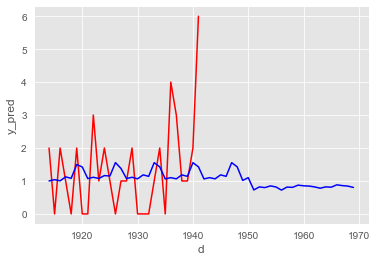

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate  l1  l2      RMSE
0  1  regression  gbdt     0.1            0   0   2.083993
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30577
[40]	valid_0's rmse: 2.1854
[60]	valid_0's rmse: 2.14417
[80]	valid_0's rmse: 2.12498
[100]	valid_0's rmse: 2.11422
[120]	valid_0's rmse: 2.10878
[140]	valid_0's rmse: 2.10417
[160]	valid_0's rmse: 2.10013
[180]	valid_0's rmse: 2.09844
[200]	valid_0's rmse: 2.09254
[220]	valid_0's rmse: 2.08642
[240]	valid_0's rmse: 2.08521
[260]	valid_0's rmse: 2.08379
[280]	valid_0's rmse: 2.08544
[300]	valid_0's rmse: 2.08829
[320]	valid_0's rmse: 2.08913
[340]	valid_0's rmse: 2.09361
[360]	valid_0's rmse: 2.09342
[380]	valid_0's rmse: 2.09022
[400]	valid_0's rmse: 2.09105
[420]	valid_0's rmse: 2.09129
[440]	valid_0's rmse: 2.09104
[460]	valid_0's rmse: 2.09084


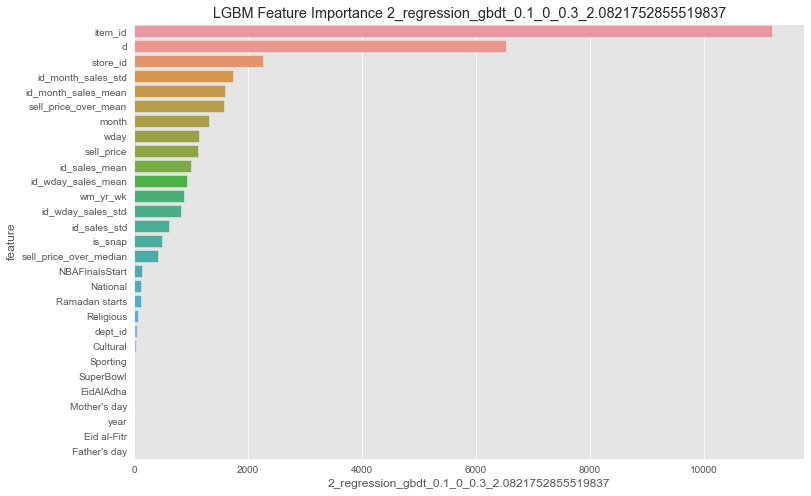

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


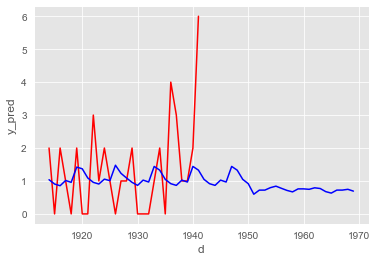

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate  l1   l2      RMSE
0  1  regression  gbdt     0.1            0   0.0  2.083993
0  2  regression  gbdt     0.1            0   0.3  2.082175
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30516
[40]	valid_0's rmse: 2.18601
[60]	valid_0's rmse: 2.14345
[80]	valid_0's rmse: 2.1229
[100]	valid_0's rmse: 2.11547
[120]	valid_0's rmse: 2.11322
[140]	valid_0's rmse: 2.10887
[160]	valid_0's rmse: 2.10665
[180]	valid_0's rmse: 2.10272
[200]	valid_0's rmse: 2.10058
[220]	valid_0's rmse: 2.09873
[240]	valid_0's rmse: 2.09682
[260]	valid_0's rmse: 2.09505
[280]	valid_0's rmse: 2.09171
[300]	valid_0's rmse: 2.08832
[320]	valid_0's rmse: 2.08691
[340]	valid_0's rmse: 2.08523
[360]	valid_0's rmse: 2.08397
[380]	valid_0's rmse: 2.08302
[400]	valid_0's rmse: 2.0822
[420]	valid_0's rmse: 2.08024

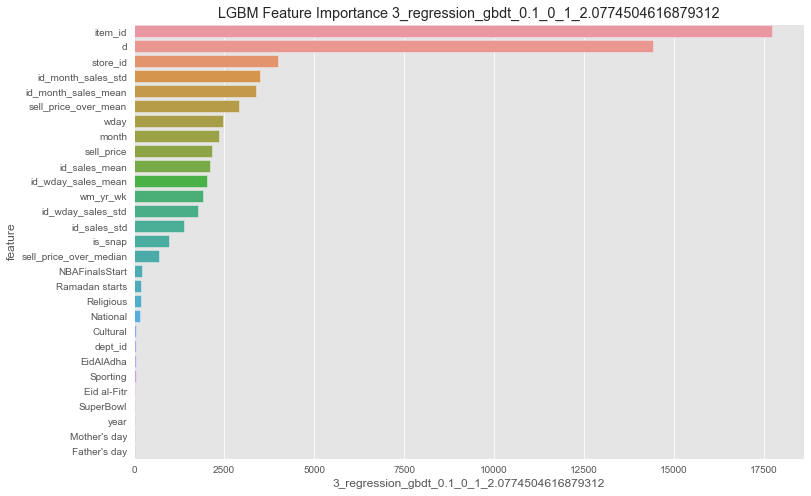

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


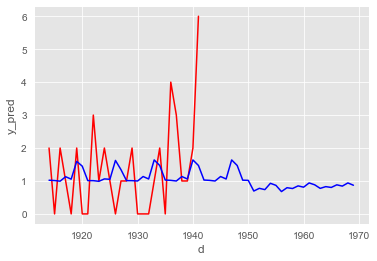

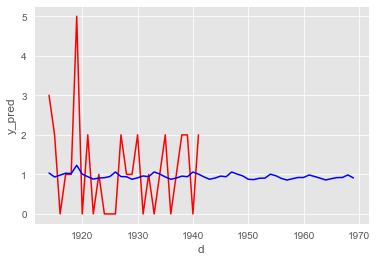

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate  l1   l2      RMSE
0  1  regression  gbdt     0.1            0   0.0  2.083993
0  2  regression  gbdt     0.1            0   0.3  2.082175
0  3  regression  gbdt     0.1            0   1.0  2.077450
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.31006
[40]	valid_0's rmse: 2.18782
[60]	valid_0's rmse: 2.14441
[80]	valid_0's rmse: 2.12716
[100]	valid_0's rmse: 2.11638
[120]	valid_0's rmse: 2.10919
[140]	valid_0's rmse: 2.10615
[160]	valid_0's rmse: 2.10364
[180]	valid_0's rmse: 2.10229
[200]	valid_0's rmse: 2.09859
[220]	valid_0's rmse: 2.09809
[240]	valid_0's rmse: 2.10149
[260]	valid_0's rmse: 2.09835
[280]	valid_0's rmse: 2.09781
[300]	valid_0's rmse: 2.09834
[320]	valid_0's rmse: 2.09705
[340]	valid_0's rmse: 2.09475
[360]	valid_0's rmse: 2.09427
[380]	valid_0's rmse: 2.093

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


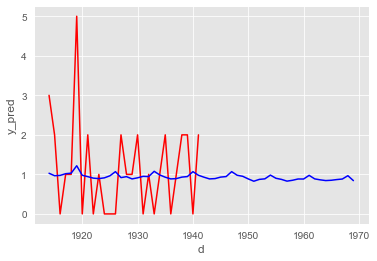

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30579
[40]	valid_0's rmse: 2.18525
[60]	valid_0's rmse: 2.14109
[80]	valid_0's rmse: 2.12455
[100]	valid_0's rmse: 2.1154
[120]	valid_0's rmse: 2.10434
[140]	valid_0's rmse: 2.09828
[160]	valid_0's rmse: 2.09605
[180]	valid_0's rmse: 2.09361
[200]	valid_0's rmse: 2.09213
[220]	valid_0's rmse: 2.09208
[240]	valid_0's rmse: 2.08649
[260]	valid_0's rmse: 2.0856
[280]	valid_0's rmse: 2.08611
[300]	valid_0's rmse: 2.08548
[320]	valid_0's rmse: 2.08422
[340]	valid_0's rmse: 2.

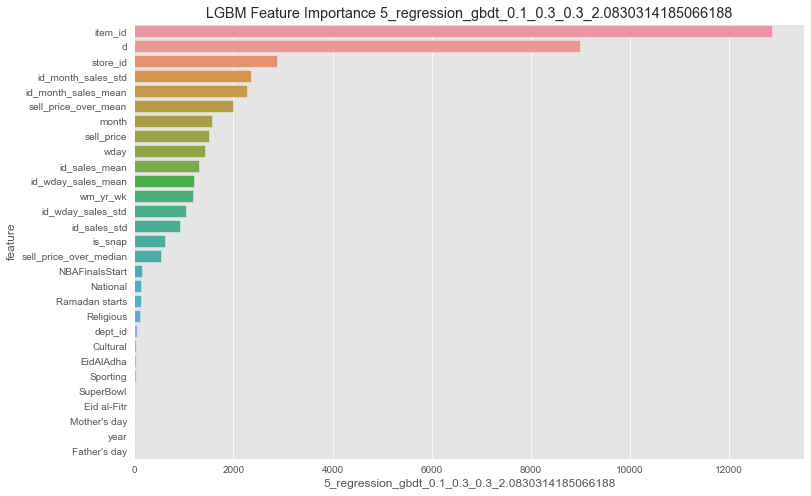

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


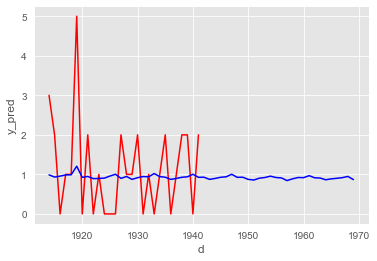

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
0  5  regression  gbdt     0.1            0.3  0.3  2.083031
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.31151
[40]	valid_0's rmse: 2.18835
[60]	valid_0's rmse: 2.14334
[80]	valid_0's rmse: 2.12206
[100]	valid_0's rmse: 2.1111
[120]	valid_0's rmse: 2.10659
[140]	valid_0's rmse: 2.10305
[160]	valid_0's rmse: 2.10013
[180]	valid_0's rmse: 2.09519
[200]	valid_0's rmse: 2.08879
[220]	valid_0's rmse: 2.08938
[240]	valid_0's rmse: 2.08812
[260]	valid_0's rmse: 2.08723
[280]	valid_0's rmse: 2.08765
[300]	valid_0's rmse: 

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
0  5  regression  gbdt     0.1            0.3  0.3  2.083031
0  6  regression  gbdt     0.1            0.3  1.0  2.080083
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.31333
[40]	valid_0's rmse: 2.18132
[60]	valid_0's rmse: 2.13861
[80]	valid_0's rmse: 2.11859
[100]	valid_0's rmse: 2.10817
[120]	valid_0's rmse: 2.10371
[140]	valid_0's rmse: 2.09493
[160]	valid_0's rmse: 2.09039
[180]	valid_0's rmse: 2.0882
[200]	valid_0's rmse: 2.08756
[220]	valid_0's rmse: 2.08766
[240]	valid_0's rmse: 2.08628
[260]	valid_0's rmse:

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


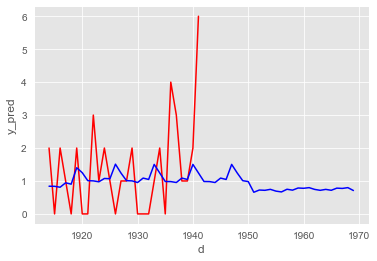

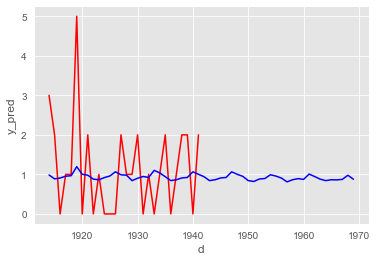

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
0  5  regression  gbdt     0.1            0.3  0.3  2.083031
0  6  regression  gbdt     0.1            0.3  1.0  2.080083
0  7  regression  gbdt     0.1            1.0  0.0  2.083441
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30679
[40]	valid_0's rmse: 2.18202
[60]	valid_0's rmse: 2.13687
[80]	valid_0's rmse: 2.11887
[100]	valid_0's rmse: 2.10818
[120]	valid_0's rmse: 2.09992
[140]	valid_0's rmse: 2.09615
[160]	valid_0's rmse: 2.09461
[180]	valid_0's rmse: 2.09136
[200]	valid_0's rmse: 2.09058
[220]	valid_0's rms

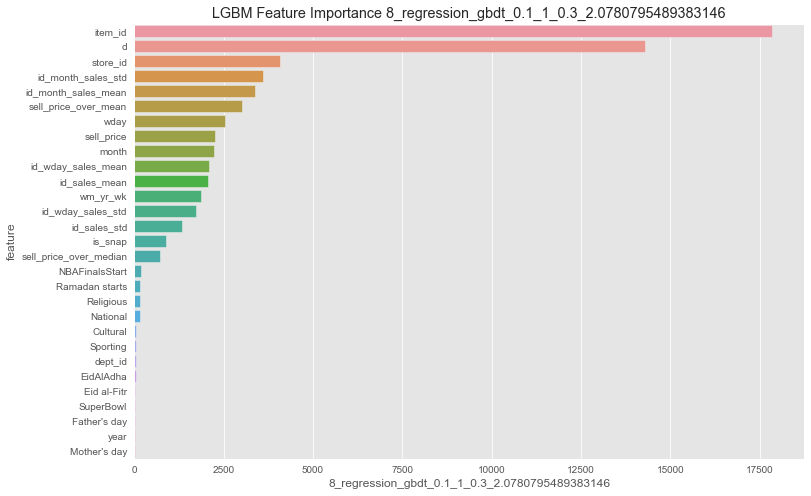

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


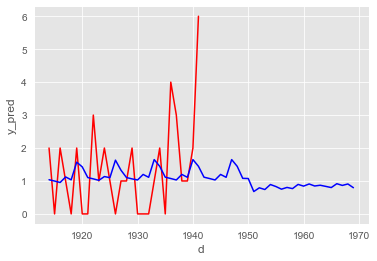

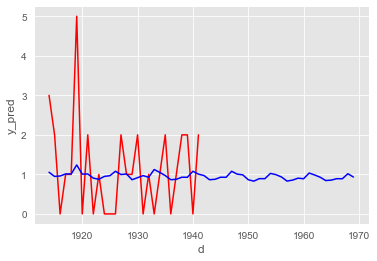

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
0  5  regression  gbdt     0.1            0.3  0.3  2.083031
0  6  regression  gbdt     0.1            0.3  1.0  2.080083
0  7  regression  gbdt     0.1            1.0  0.0  2.083441
0  8  regression  gbdt     0.1            1.0  0.3  2.078080
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.30749
[40]	valid_0's rmse: 2.18197
[60]	valid_0's rmse: 2.14389
[80]	valid_0's rmse: 2.12455
[100]	valid_0's rmse: 2.11835
[120]	valid_0's rmse: 2.11149
[140]	valid_0's rmse: 2.10425
[160]	valid_0's rmse: 2.09985
[180]	valid_0's rm

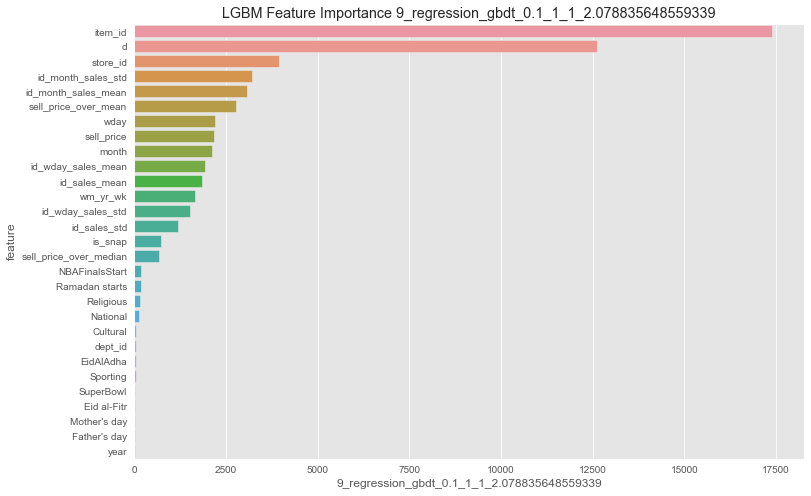

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


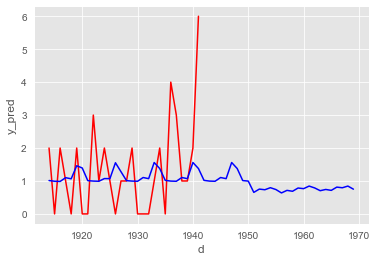

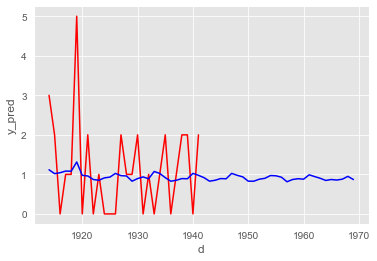

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
   i   objective boosting  learning_rate   l1   l2      RMSE
0  1  regression  gbdt     0.1            0.0  0.0  2.083993
0  2  regression  gbdt     0.1            0.0  0.3  2.082175
0  3  regression  gbdt     0.1            0.0  1.0  2.077450
0  4  regression  gbdt     0.1            0.3  0.0  2.093309
0  5  regression  gbdt     0.1            0.3  0.3  2.083031
0  6  regression  gbdt     0.1            0.3  1.0  2.080083
0  7  regression  gbdt     0.1            1.0  0.0  2.083441
0  8  regression  gbdt     0.1            1.0  0.3  2.078080
0  9  regression  gbdt     0.1            1.0  1.0  2.078836
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.14629
[40]	valid_0's rmse: 2.12774
[60]	valid_0's rmse: 2.11807
[80]	valid_0's rmse: 2.1066
[100]	valid_0's rmse: 2.10285
[120]	valid_0's rmse: 2.10421
[140]	valid_0's rm

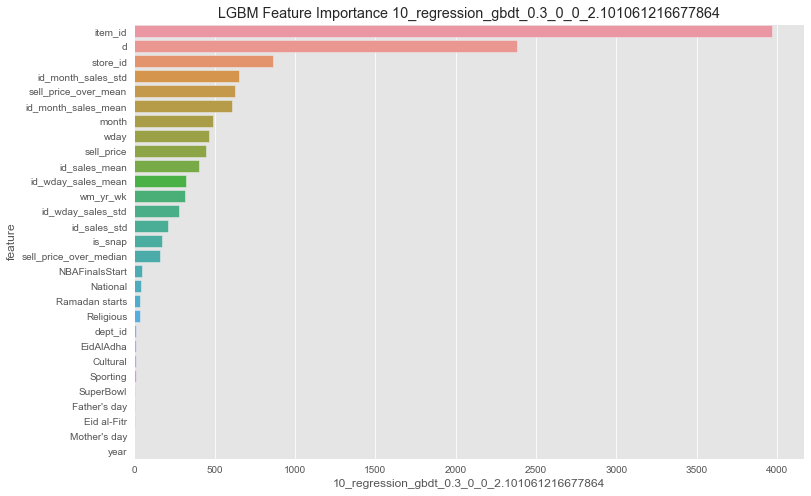

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


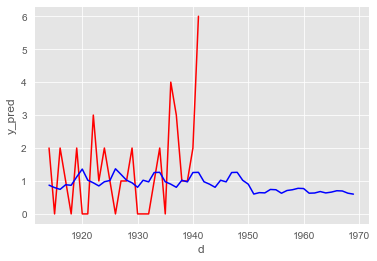

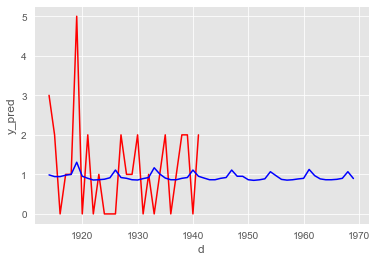

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.15151
[40]	valid_0's rmse: 2.12085
[60]	valid_0's rmse: 2.1135
[80]	valid_0's rmse: 2.10637
[100]	

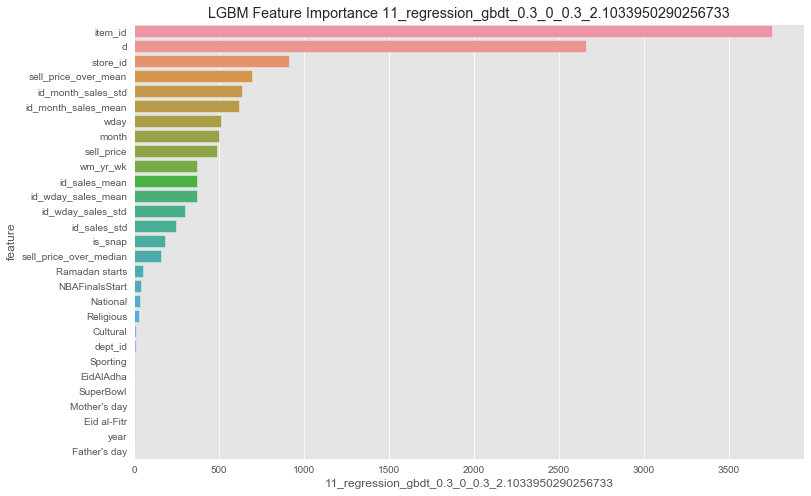

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


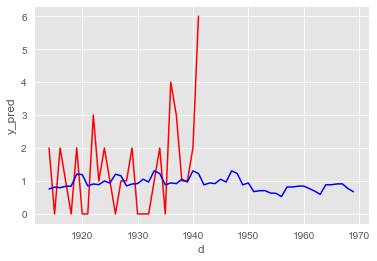

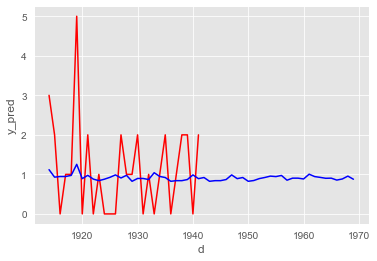

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
-------------------------
Training until validation scores don't improve for 500 rounds
[20]	valid_0's rmse: 2.14994
[40]	valid_0's rmse: 2.11168
[

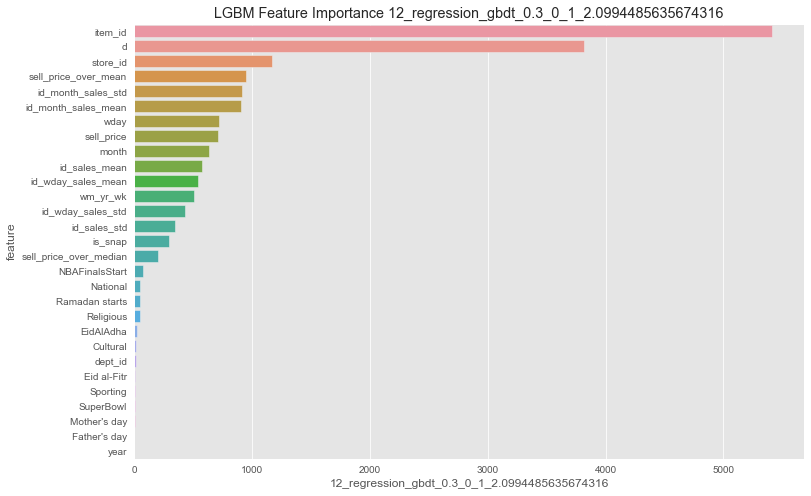

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


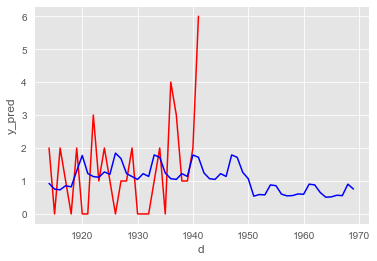

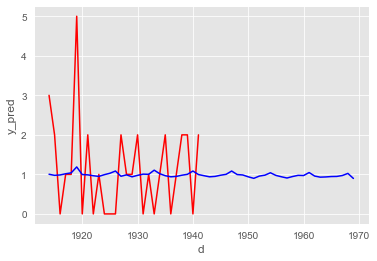

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
-------------------------
Training until validation scores don't improve for 500 roun

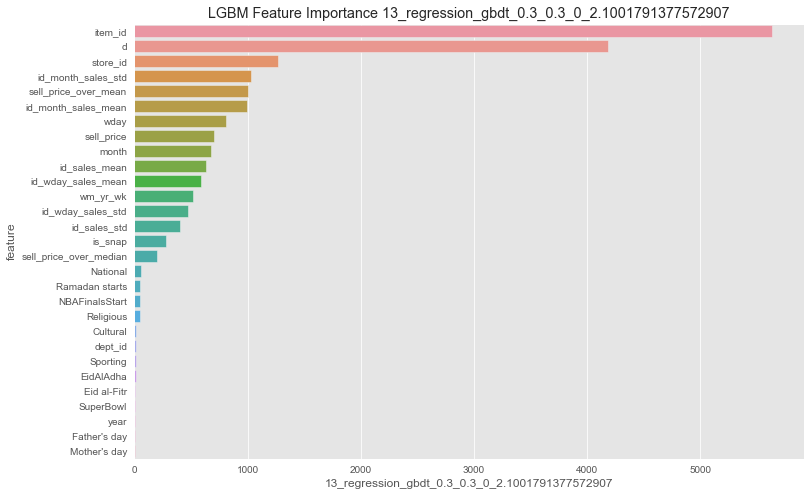

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


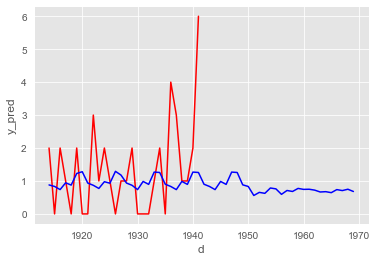

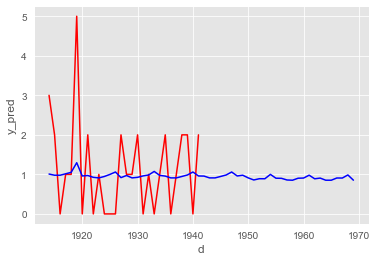

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
-----------------------

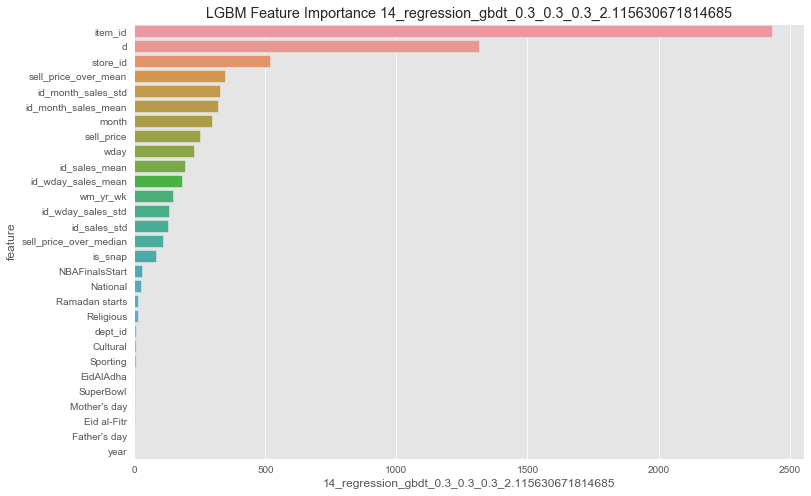

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


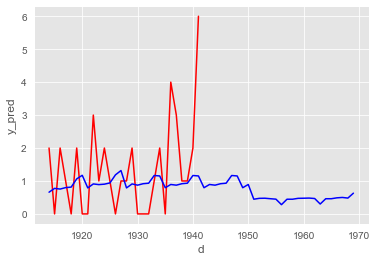

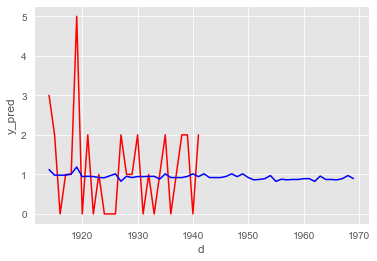

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

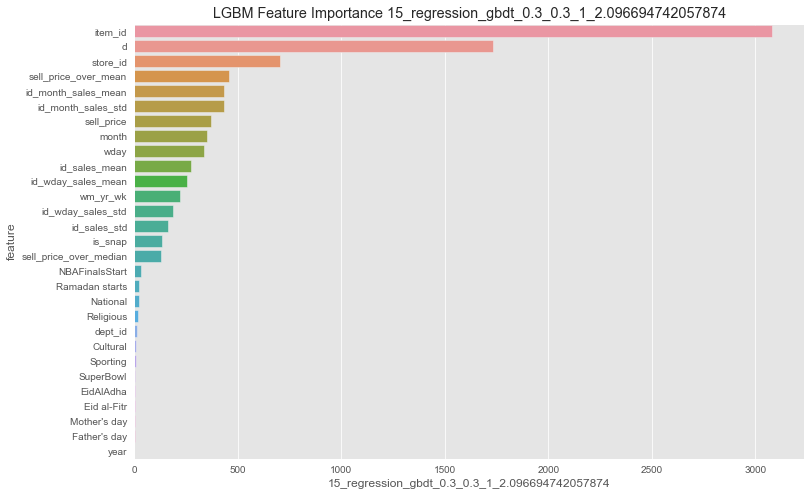

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


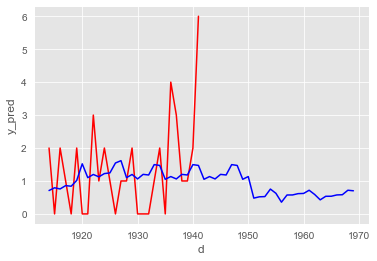

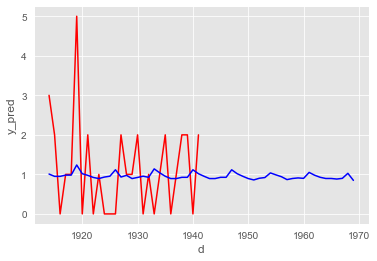

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

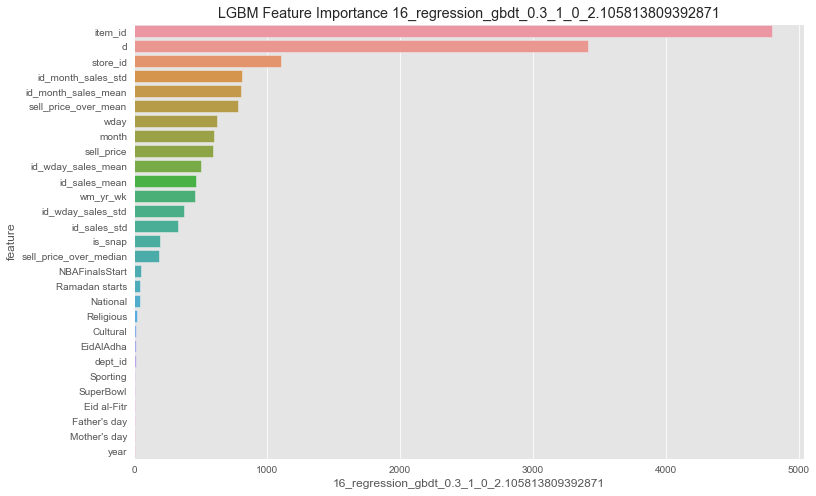

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


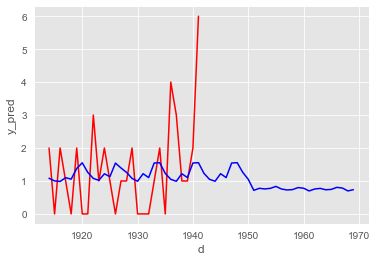

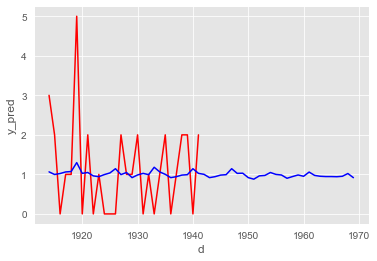

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

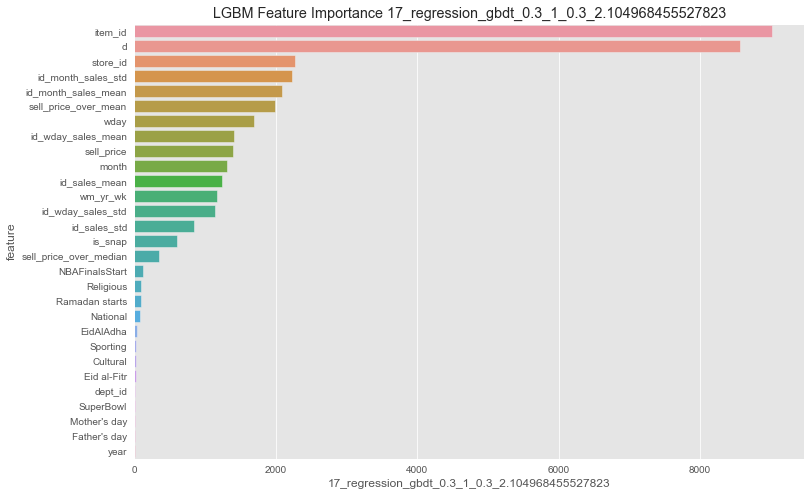

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


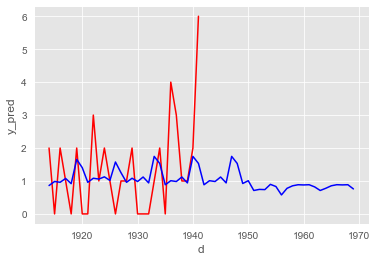

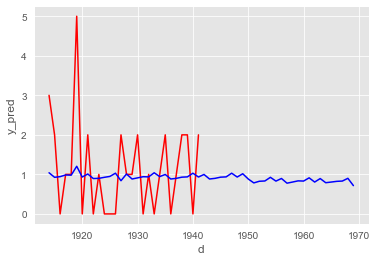

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

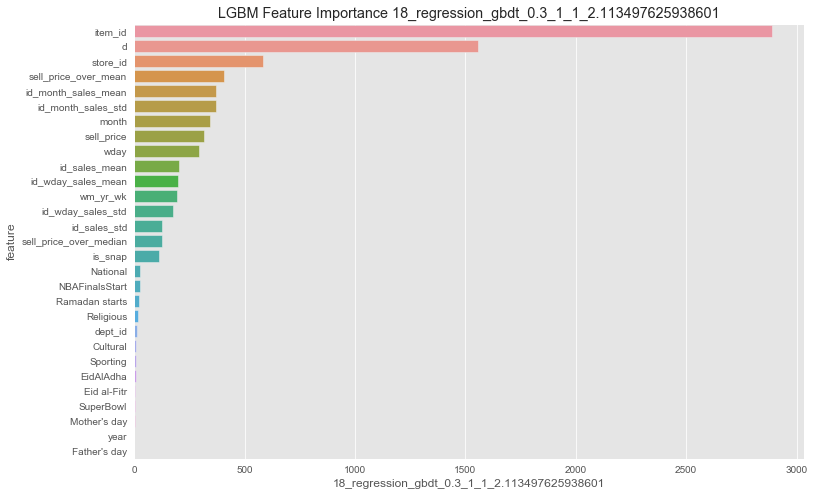

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


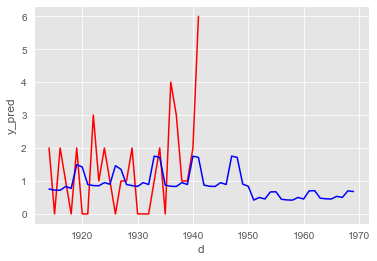

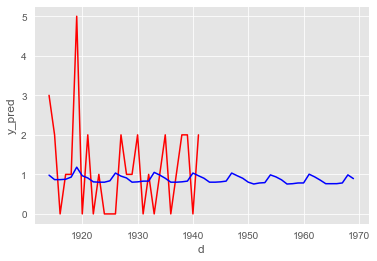

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

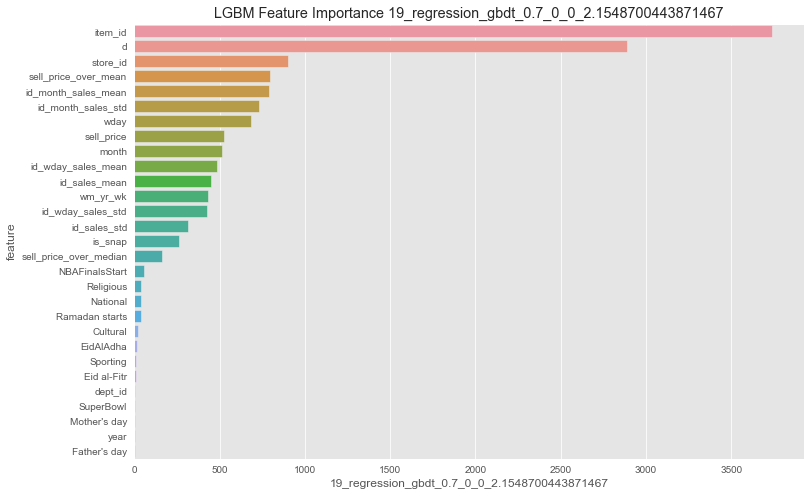

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


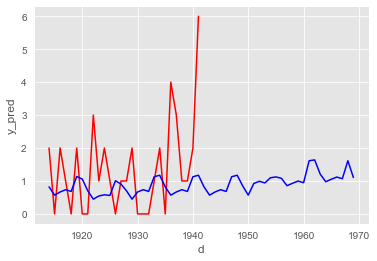

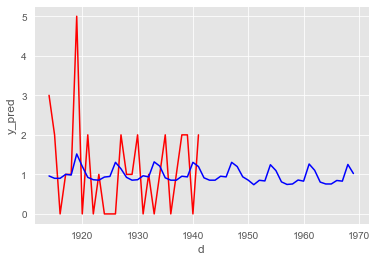

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

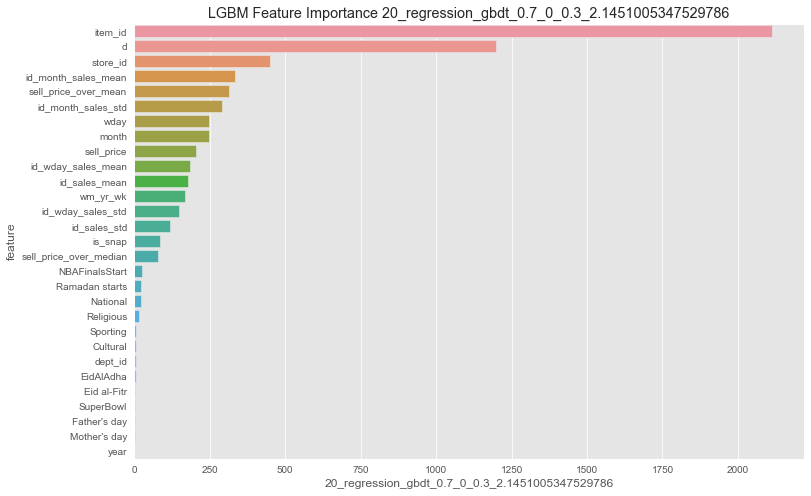

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


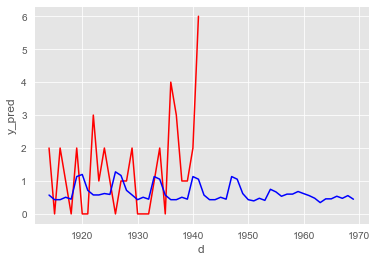

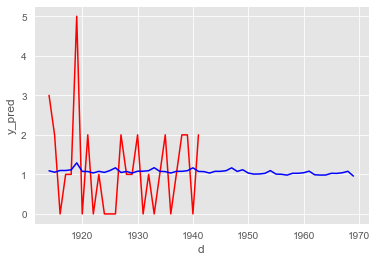

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

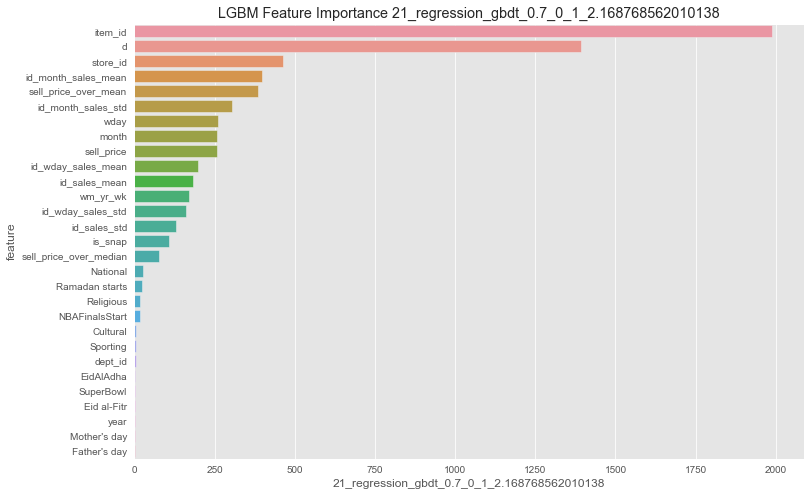

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


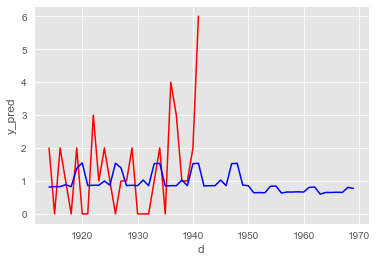

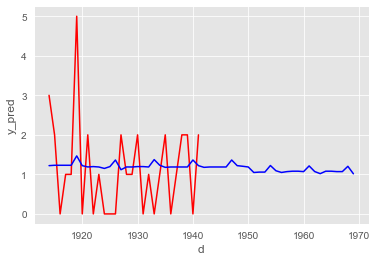

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

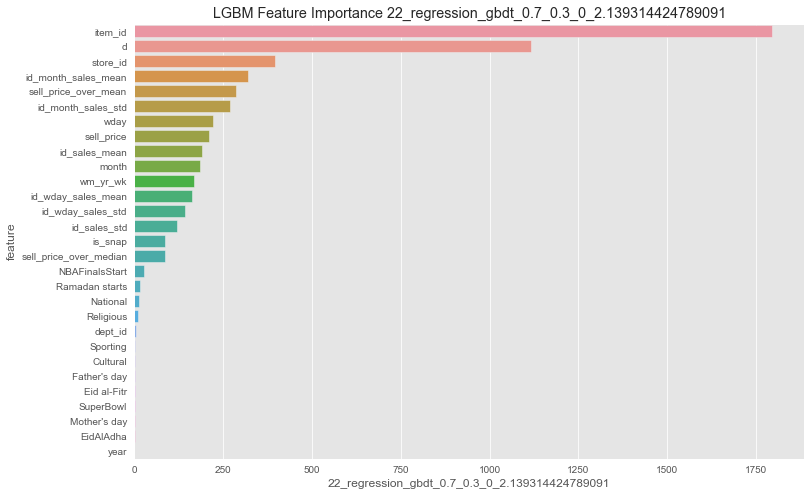

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


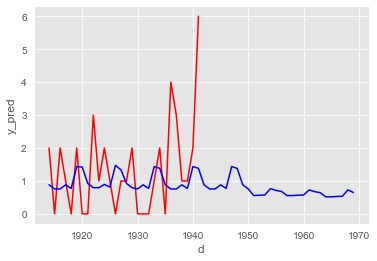

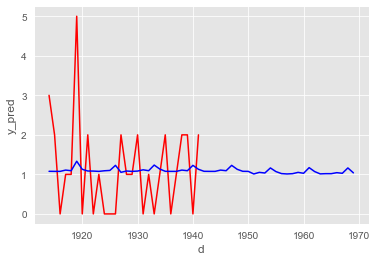

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

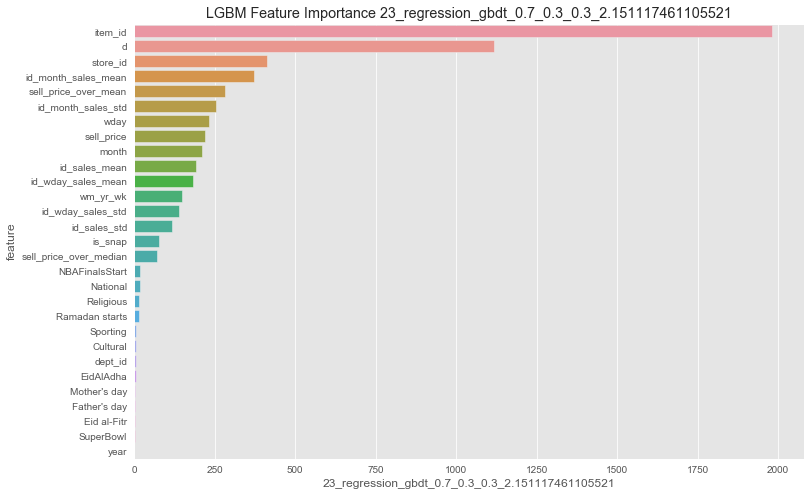

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


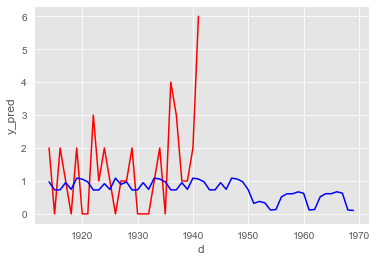

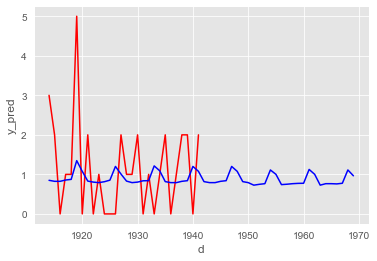

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

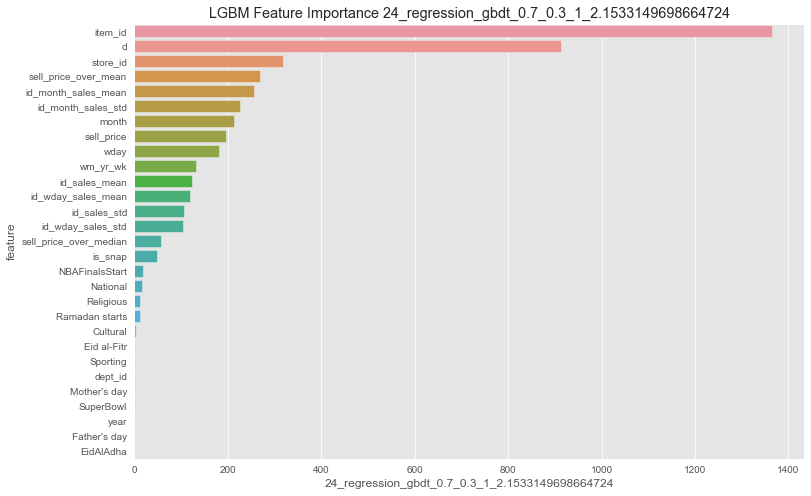

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


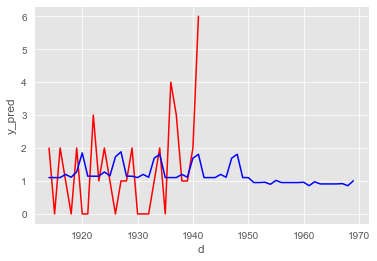

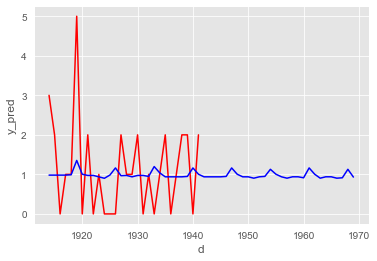

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

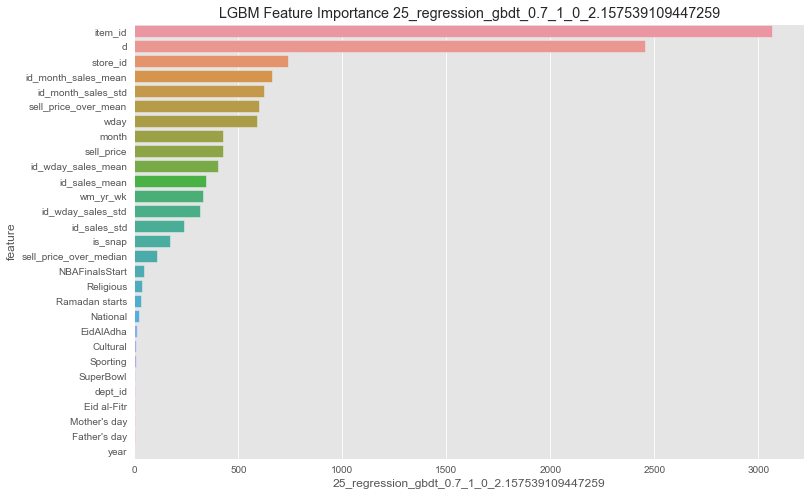

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


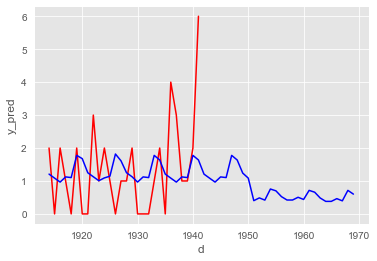

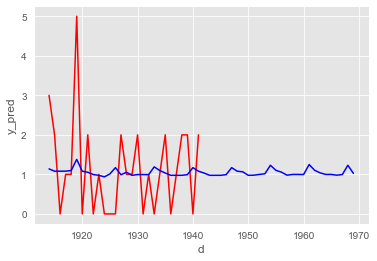

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

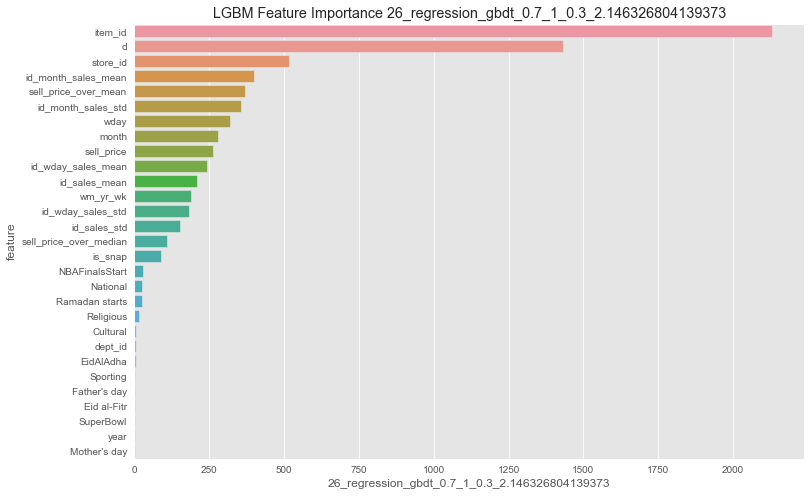

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


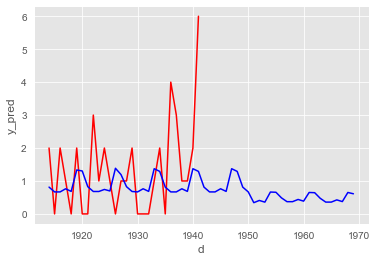

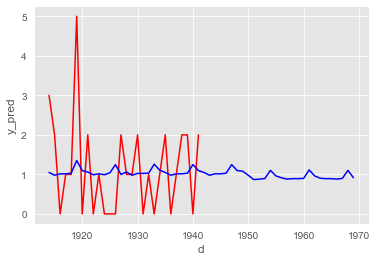

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

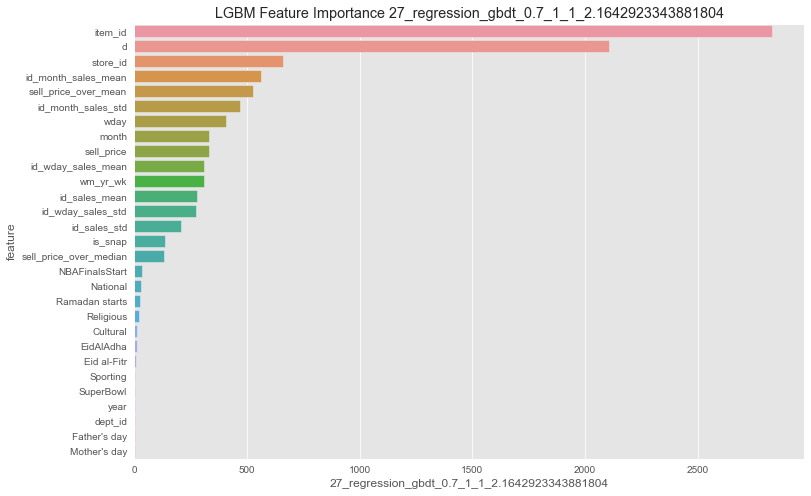

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


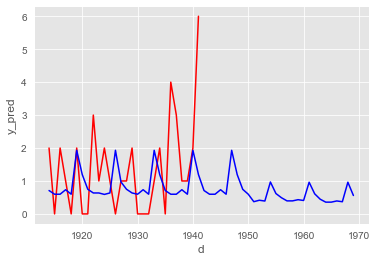

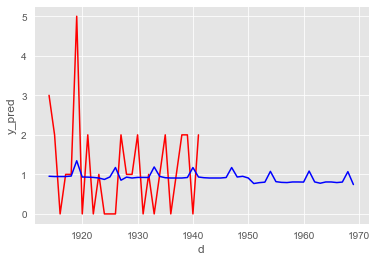

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

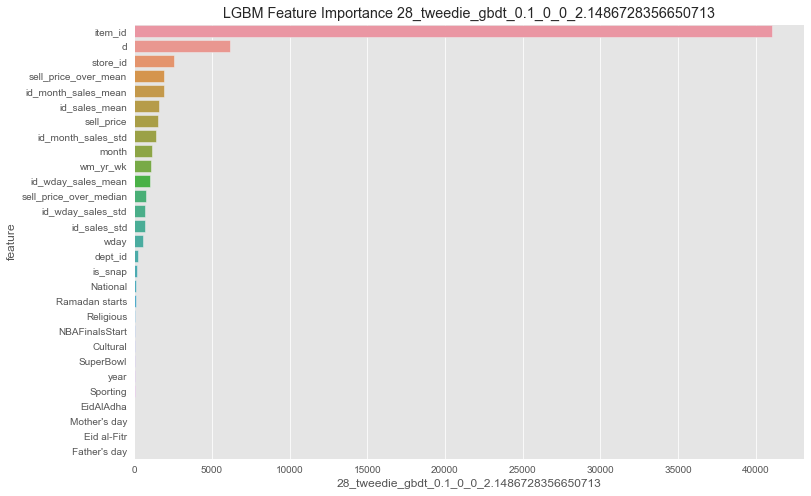

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


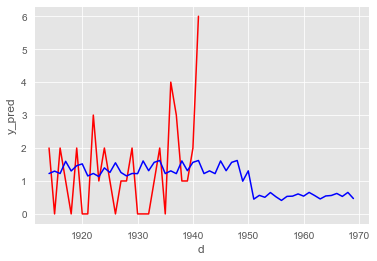

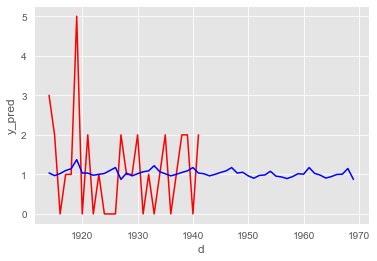

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

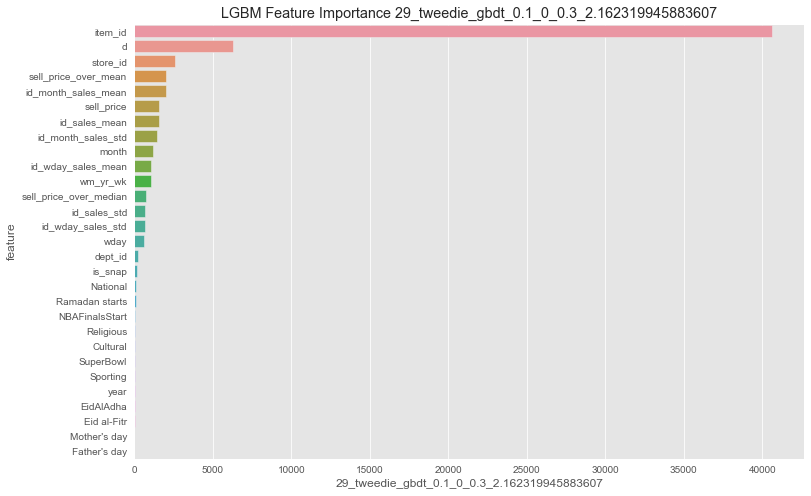

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


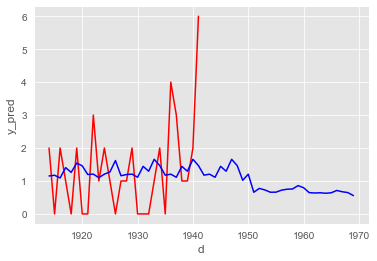

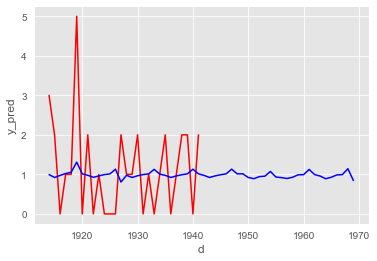

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

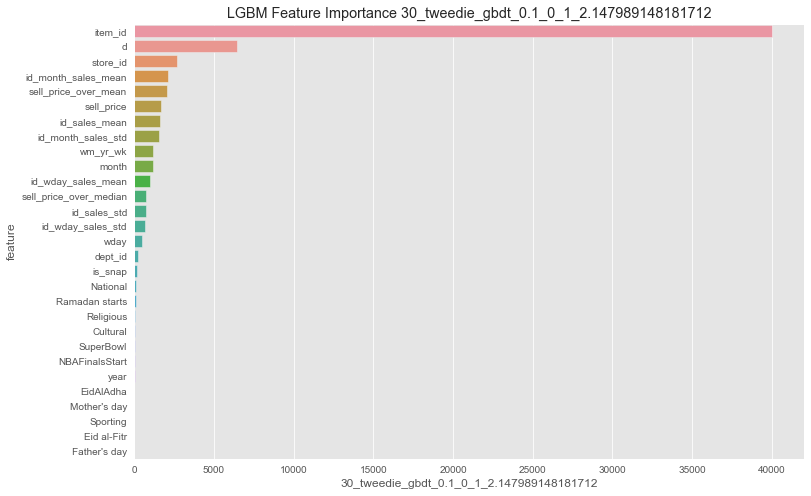

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


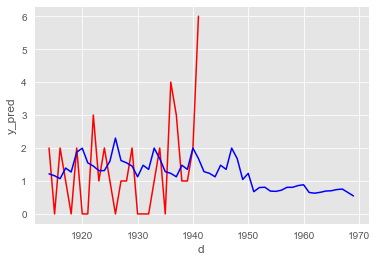

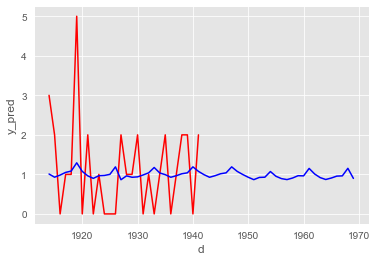

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

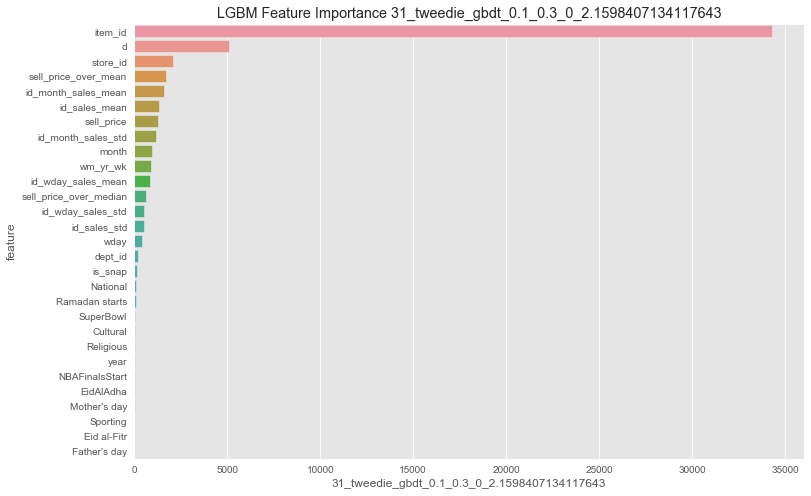

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


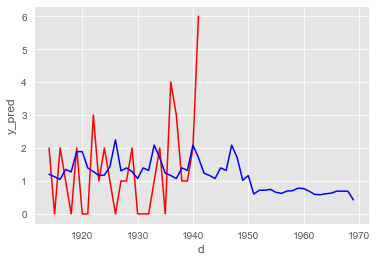

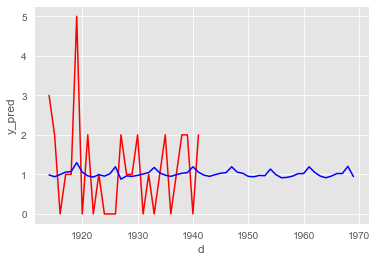

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

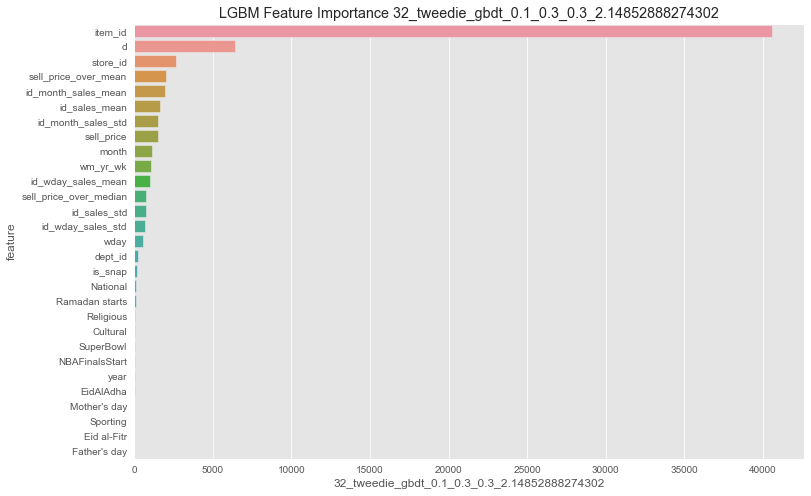

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


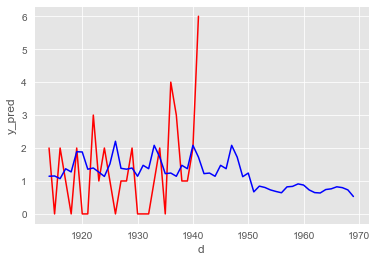

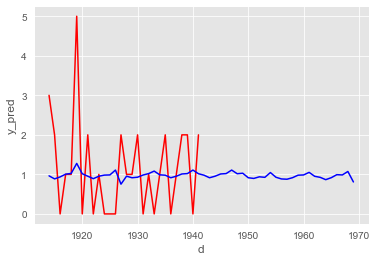

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

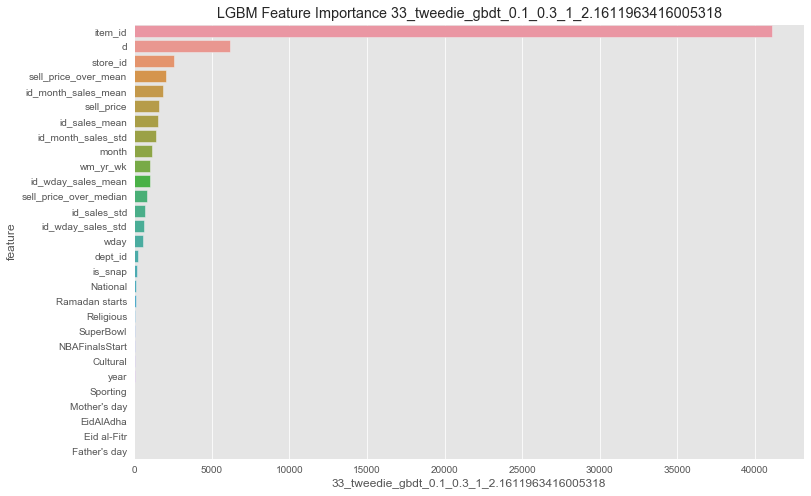

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


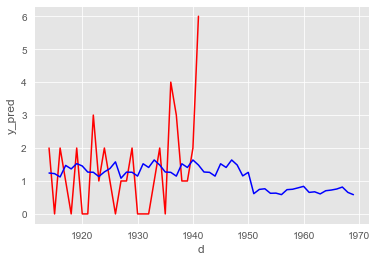

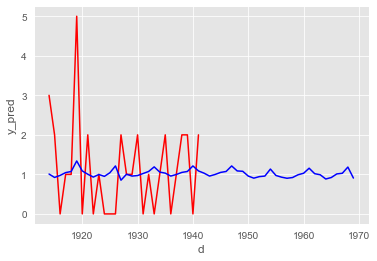

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

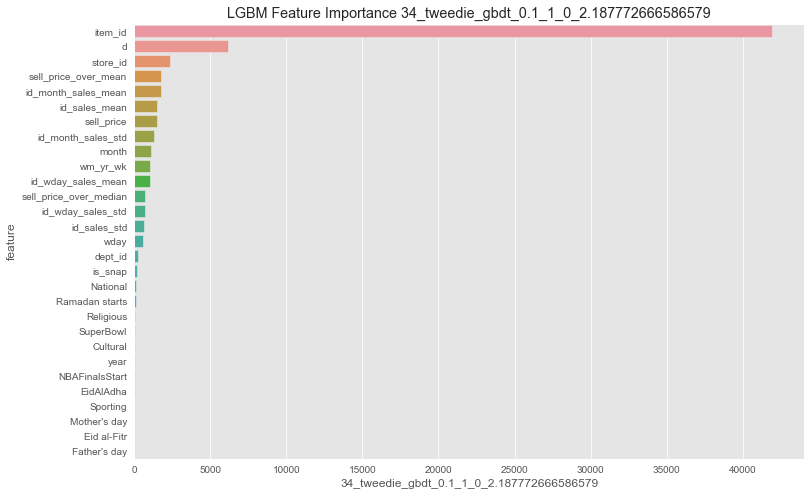

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


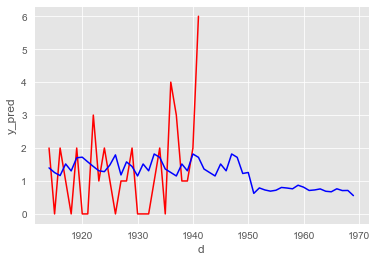

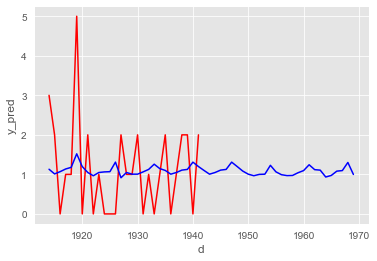

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

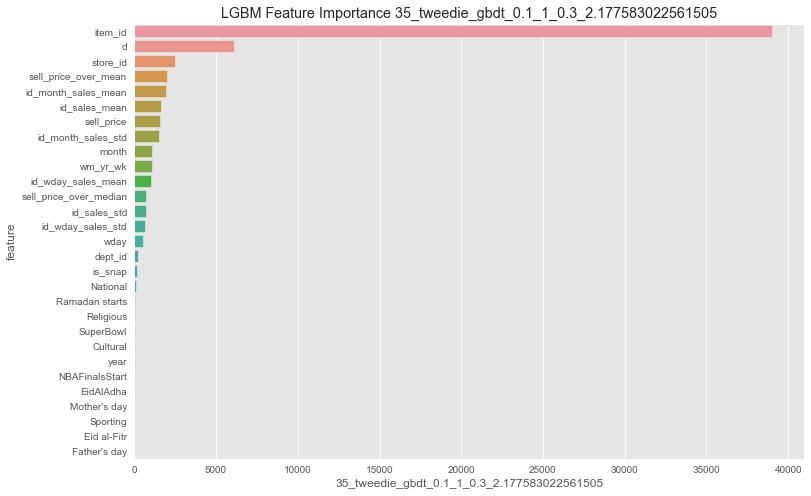

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


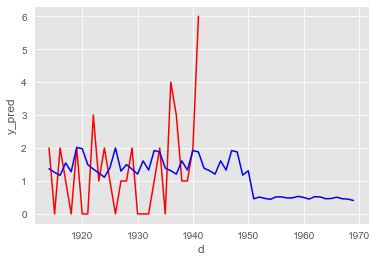

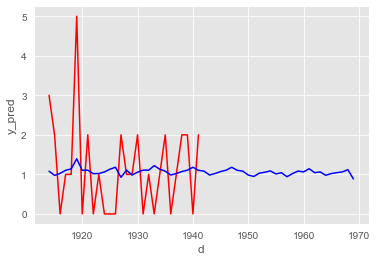

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


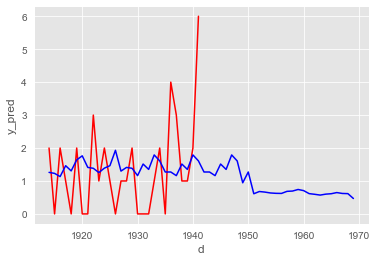

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

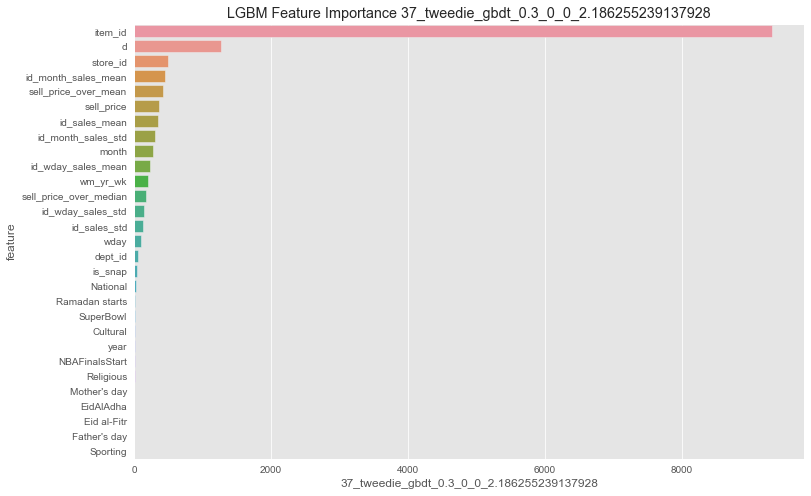

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


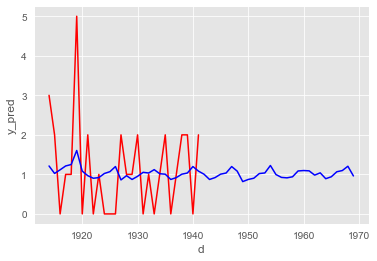

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


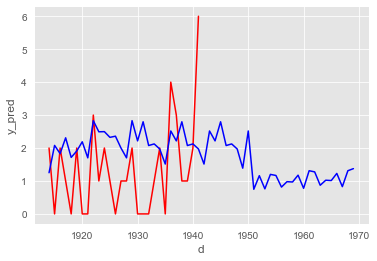

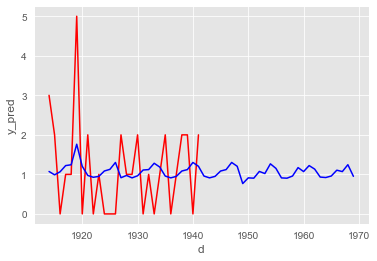

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

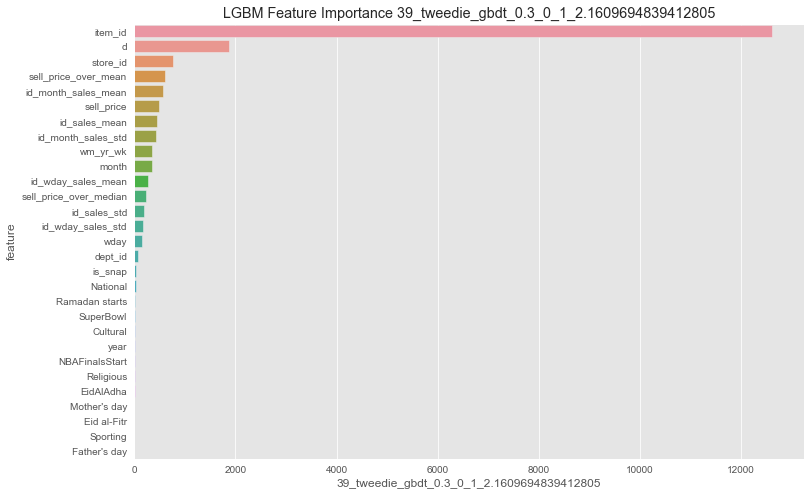

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

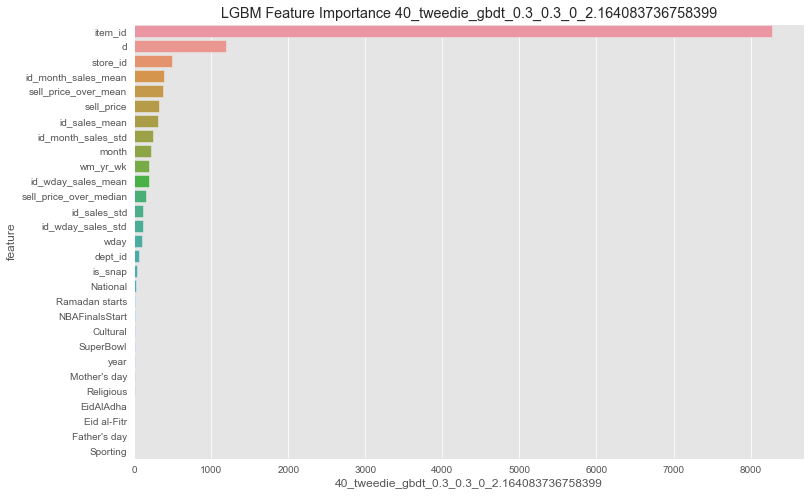

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


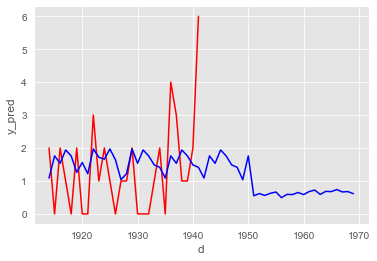

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


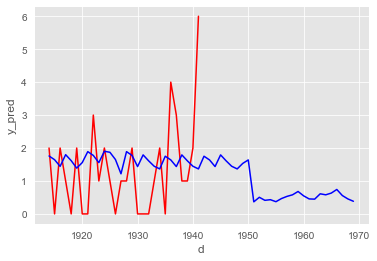

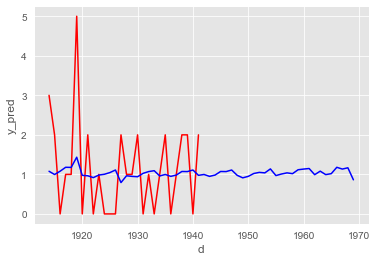

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

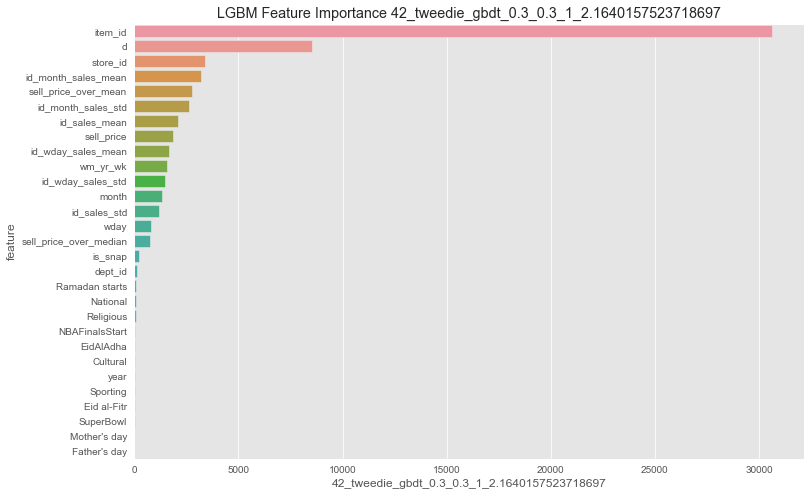

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

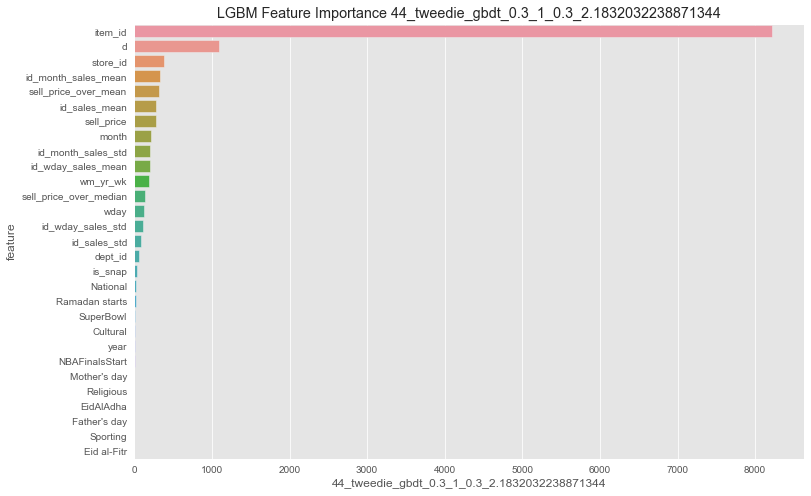

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


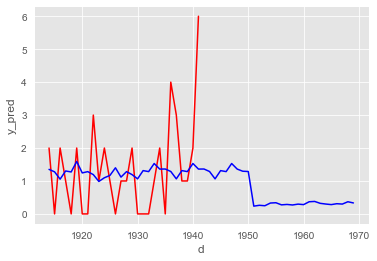

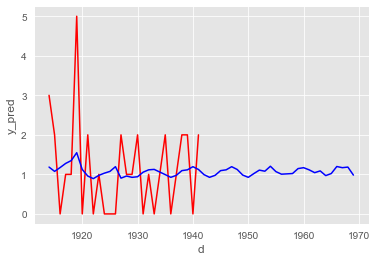

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


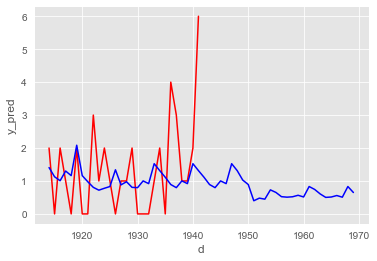

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


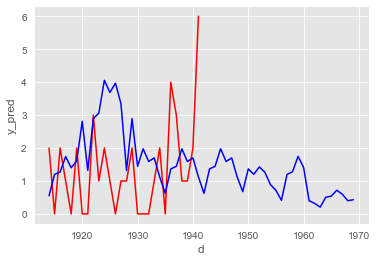

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

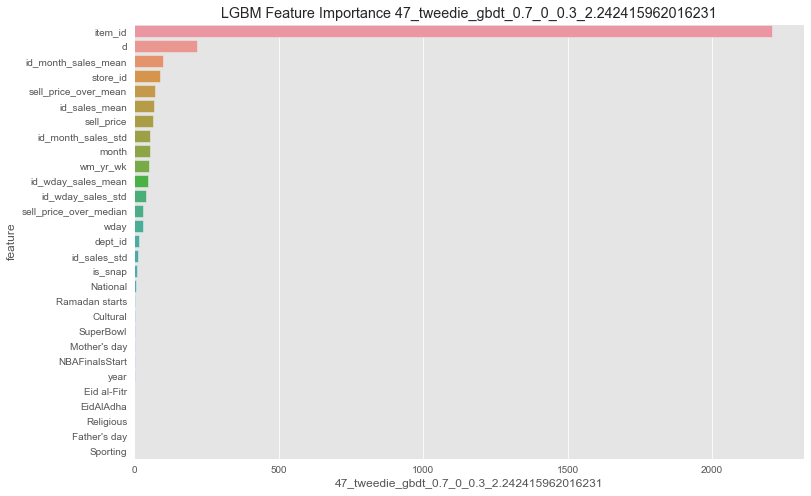

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


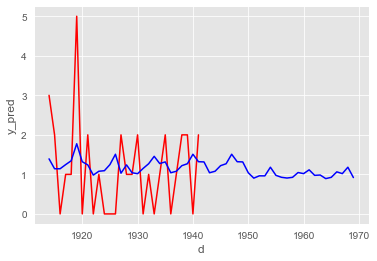

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


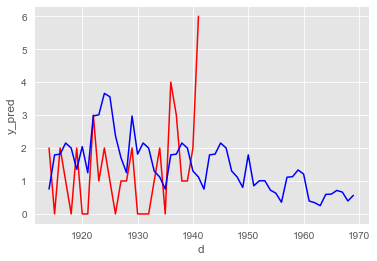

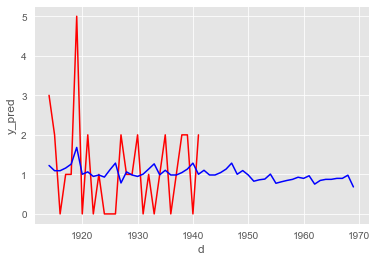

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


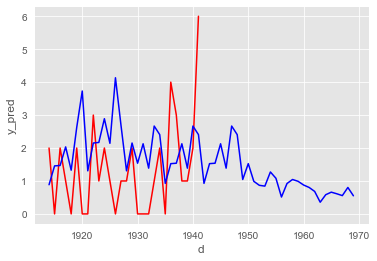

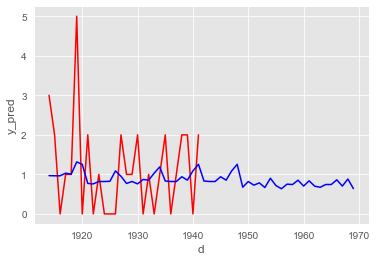

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

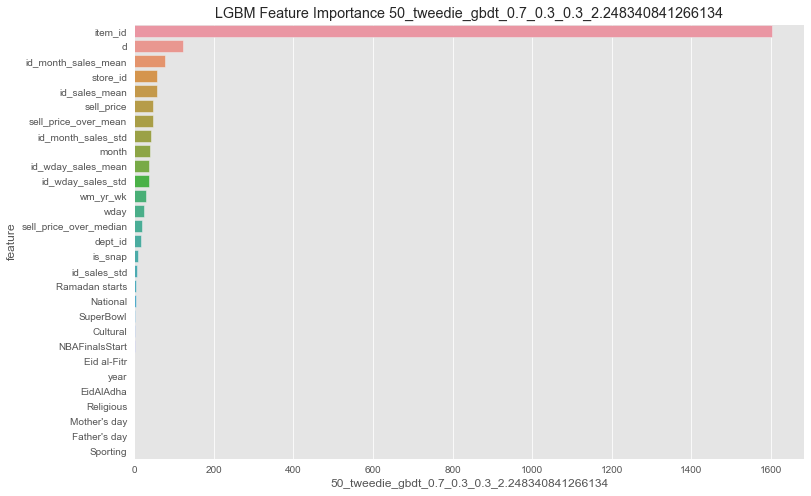

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


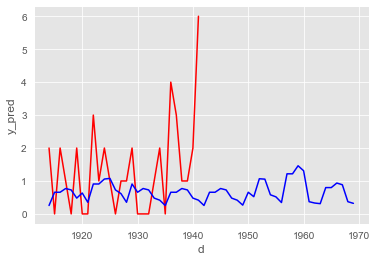

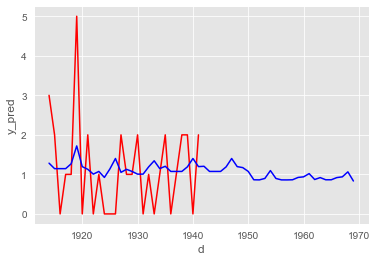

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

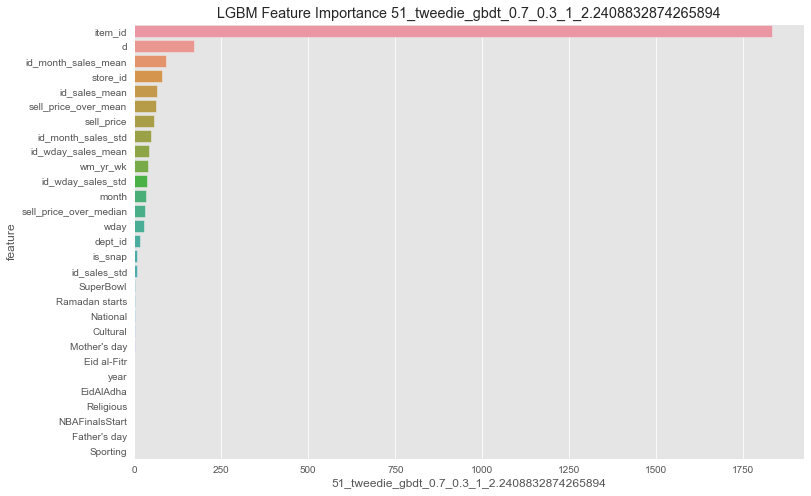

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


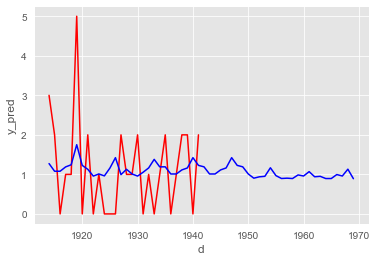

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

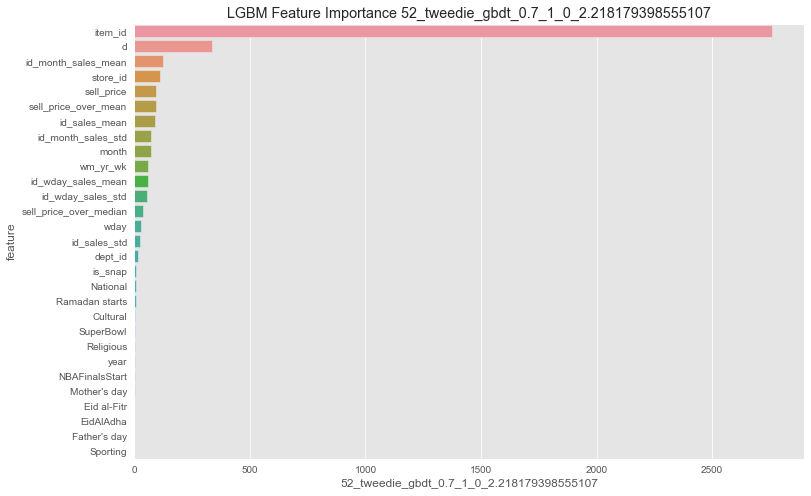

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


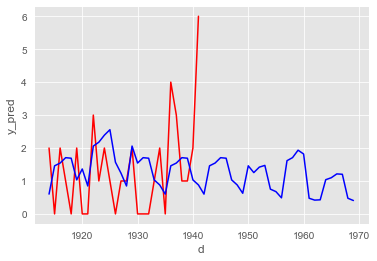

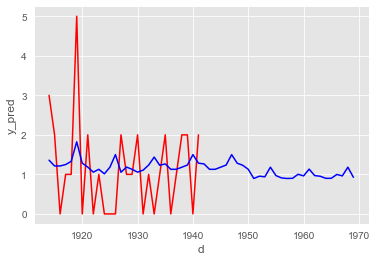

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

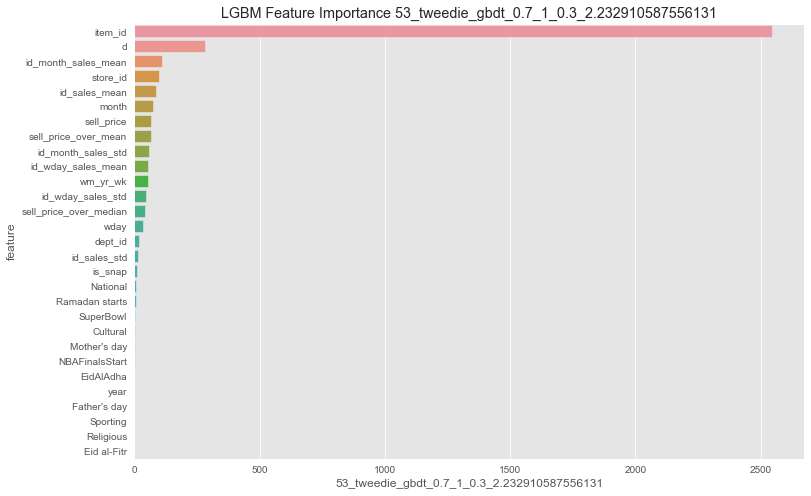

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


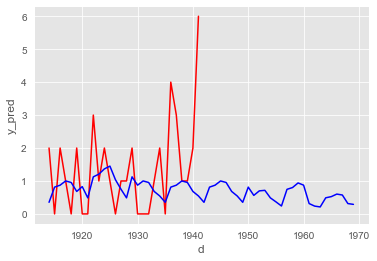

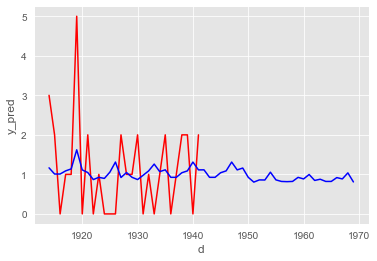

-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

-------------------------
MODEL PREDICTION BEGAN ...
-------------------------


-------------------------
MODEL PREDICTION COMPLETED !!!
-------------------------
-------------------------
    i   objective boosting  learning_rate   l1   l2      RMSE
0  1   regression  gbdt     0.1            0.0  0.0  2.083993
0  2   regression  gbdt     0.1            0.0  0.3  2.082175
0  3   regression  gbdt     0.1            0.0  1.0  2.077450
0  4   regression  gbdt     0.1            0.3  0.0  2.093309
0  5   regression  gbdt     0.1            0.3  0.3  2.083031
0  6   regression  gbdt     0.1            0.3  1.0  2.080083
0  7   regression  gbdt     0.1            1.0  0.0  2.083441
0  8   regression  gbdt     0.1            1.0  0.3  2.078080
0  9   regression  gbdt     0.1            1.0  1.0  2.078836
0  10  regression  gbdt     0.3            0.0  0.0  2.101061
0  11  regression  gbdt     0.3            0.0  0.3  2.103395
0  12  regression  gbdt     0.3            0.0  1.0  2.099449
0  13  regression  gbdt     0.3            0.3  0.0  2.100179
0  14  regression  gbdt

In [50]:
res_rmse = pd.DataFrame()
feature_importances = pd.DataFrame()
feature_importances['feature'] = feature_columns_to_keep


obj_list   = [ 'regression', 'tweedie' ]
boost_list = [ 'gbdt']
lr_list    = [ 0.1, 0.3, 0.7 ]
l1_list    = [ 0, 0.3, 1  ]
l2_list    = [ 0, 0.3, 1 ]

i=0


for obj in obj_list:
    for boost in boost_list:
        for lr in lr_list: 
            for l1 in l1_list:
                for l2 in l2_list:
                    i += 1
                                        
                    params = {
                    # 'regression', 'regression_l1', 'tweedie',  'poisson', 'quantile', 'gamma', 'multiclass', 'cross_entropy'
                    'objective'         : obj        ,
                        
                    #
                    # 'num_class'         : len(set(train_data.label)) ,

                    # 'gbdt', 'rf', 'dart', 'goss'
                    'boosting'          : boost      ,

                    # number of boosting iterations (100)  - [0, )
                    'num_iterations'    : 511        ,    

                    # shrinkage rate (0.1) - [0, )
                    'learning_rate'     : lr         ,

                    # 'serial', 'feature', 'data', 'voting'
                    'tree_learner'      : 'serial'   ,

                    # if there are too many rows make it True, if there are too many columns make 'force_col_wise' option True
                    # Never make them both True
                    'force_row_wise'    : True       ,

                    # if the data is small use it otherwise don't touch it
                    'max_depth'         : -1         ,

                    # 20 - [0, )
                    'min_data_in_leaf'  : 31         , 

                    # randomly select part of data without resampling, to enable bagging it must be smaller than 1 (0,1]
                    # 'bagging_fraction'  : 1          ,

                    # to enable bagging bagging_freq must be nonzero [0, )
                    #'bagging_freq'      : 0          ,

                    # randomly select features, to enable featuring it must be smaller than 1 (0,1]
                    # 'feature_fraction'  : 1          ,

                    # stops training if one metric of one validation data does not improve in the last x rounds (0)
                    'early_stopping_round' : 500     ,

                    # (0)
                    'lambda_l1'         : l1         ,

                    # (0)
                    'lambda_l2'         : l2          ,

                    #controls the level of LGBM verbosity
                    'verbosity'         : 1          ,  

                    # 'rmse', 'auc', 'l1', 'l2', 'tweedie', 'poissson', 'multi_logloss'..
                    'metric'            : 'rmse'      ,
                        
                    # Use these 3 parameters to handle memory error
                    # -----------------------------------------------------
                    # max number of leaves in one tree (31) - [1,131072]
                    'num_leaves'              : 128    , 
                    # max cache size in MB for historical histogram (-1)
                    #'histogram_pool_size'     : 128   ,
                    # max number of bins that feature values will be bucketed in (255) - 
                    #'max_bin'                 : 31    ,
                    # -----------------------------------------------------
                        
                    'random_state': 28,

                    }

                    with timer():
                        model = lgb.train(params, train_data, 2000,  valid_sets = [valid_data], verbose_eval=20 ) 
                        mtrc_rmse = model.best_score['valid_0']['rmse']
                        param_name = f'{i}_{obj}_{boost}_{str(lr)}_{str(l1)}_{str(l2)}_{str(mtrc_rmse)}'
                    
                    
                    model.save_model(f'{out_path}model_lgbm_1_' + param_name + '.txt')

                    res_rmse = res_rmse.append( pd.DataFrame( {  'i': [i],
                                             'objective': [obj],
                                             'boosting': [boost],
                                             'learning_rate':[lr], 
                                             'l1':[l1], 
                                             'l2':[l2], 
                                             'RMSE': [mtrc_rmse]  } ) )
                    
                    feature_importances[param_name] = model.feature_importance()               

                    plt.figure( figsize=(12,8) )
                    sns.barplot( x    = param_name,
                                 y    = 'feature',
                                 data = feature_importances.sort_values(param_name, ascending = False ) )
                    plt.title('LGBM Feature Importance ' + param_name)
                    plt.show()
                    
                    predictor(model, pred, y_true, param_name, submission)

                    print('-'*25)
                    print( res_rmse )
                    print('-'*25)

                
res_rmse.to_excel(f'{out_path}res_rmse.xlsx', index=False)                 
feature_importances.to_excel(f'{out_path}feature_importances.xlsx', index=False) 